# Propensity Score Analysis

## FPMD 7030 Modern Causal Inference, University of Utah 
Author: Meghan Broadbent  
Analysis: IRKernal (R) in a Jupyter Notebook

 ---------------------------------------------------------------------------------------------------------------------

The purpose of this analysis is to answer the following, *“Does quitting smoking cause you to gain weight?”*  
   
We will use a subset of the publically available of the NHEFS data used by Miguel Hernan and Jamie Robins in their online book “Causal Inference”. This subset contains data on 1,566 cigarette smokers aged 25-74 years who, as part of the NHEFS, had a baseline visit (between 1971 and 1975) and a follow-up visit about 10 years later (1982). The dataset is further restricted to NHEFS individuals with non-missing sex, age, race, weight, height, education, alcohol use and intensity of smoking at the baseline (1971-75) and follow-up (1982) visits, and who answered the general medical history questionnaire at baseline.  
  
Individuals are classified as treated if they reported having quit smoking before the follow-up visit, and as untreated if otherwise. Everyone’s weight gain was measured (in kg) as the body weight at the follow-up visit minus the body weight at the baseline visit.

*Note: For the purpose of this assignment, focus will be on model building and will deal with simple methods of imputation for continuous variables with missing data. There will be no focus on the 63 censored samples where final weight change was not measured, rather we focus on those whom finished the study to last follow up*



### 1. First construct a causal diagram for the question of interest

The construction of DAG is critical in an analysis as we need to identify which variables to include and which to not include. The list of variables from this study is long, and I have decreased the amount of variables to only a handful (although more could be put into the model).  
  
For this study, 'treatment assignment' is in the perspective of trying to push an observational study as close as we can to that of an RCT. In RCTs, the treatment assignment is actively manipulated by an investigator, whereas in observational studies, individuals are thought of as assigning themselves to a group. Hence, in this study, a portion of the population assigned themselve to quit smoking, while the rest did not. The major difference here is that individual assignment is not done randomly, and thus we'll use a DAG along side our propensity score to balance out the population for a better comparison.  
  
If you are familiar with study design and DAGs, then you will know to avoid instrumental variables (IVs) in your model (variables associated only with the treatment assignment, or strongly associated with the treatment outcome and only weakly associated with the outcome of interest). Thus variables such as `bronchitis`, `asthma`, etc were excluded from the analysis, as these can be seen as associated only with the 'treatment assignment'. In addition, we know to include pre-treatment variables only, thus variables such as `sbp`, `dbp`, `tax82`, etc were avoided. Remember, our goal is to balance out the population of non-smokers and smokers in regards to their characteristics associated with their changes in weight over time.    

Model selection in causal methods or propensity score methods should be taken with great care, stepwise approaches to model selection or variable selection based on statistical significance should really be avoided. Machine learning algorithms are also popular, but they are a blackbox approach and ignore variables such IVs (should not be included) that will bias your end result toward the null. A sufficient literature review or discussion with subject matter experts is highly recommended in addition to a review of each variable in the model (if possible). 

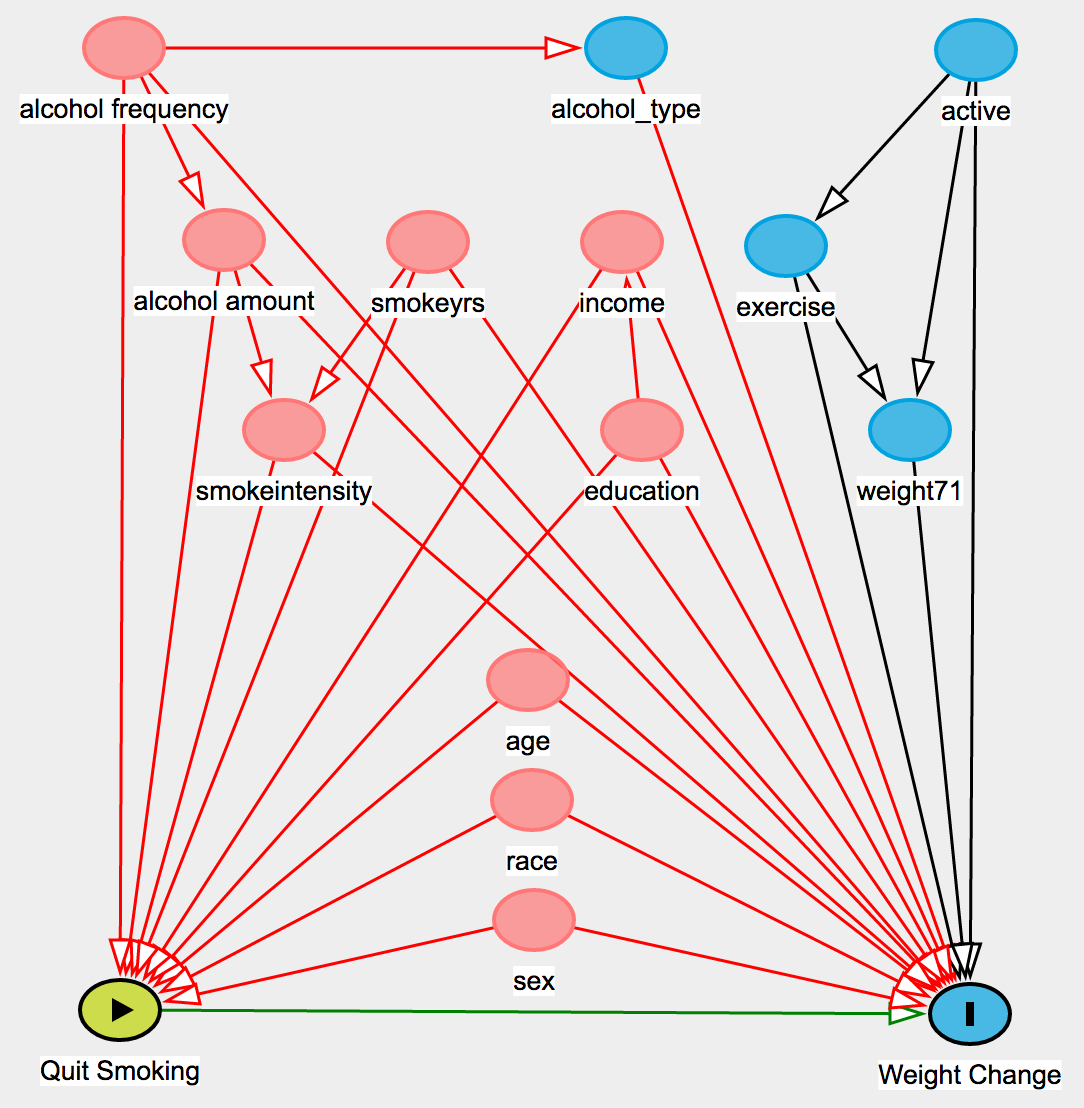

In [513]:
#DAG image
library("IRdisplay")
display_png(file="dg1.png")

In [200]:
#create a vector of these column variables names we wish to include in our model
include_covar = c("active", "age", "alcoholfreq", "alcoholhowmuch", 
                    "alcoholtype", "education", "exercise", "income", 
                    "race", "sex", "smokeintensity", 
                    "smokeyrs", "wt71")

The variables I've identified as confounders are:  `age`, `alcoholfreq`, `alcoholhowmuch, alcoholtype, education, exercise, income, race, sex, smokeintensity, smokeyrs`.  

The variables I've identified as risk factors associated with the outcome (weight gain) are:  `active, exercise, wt71`.  

There are other variables that could be debated on their inclusion or not, such as `tax71`. If there is a variable you believe should or should not be added to your model, be sure to justify it either way. If one was to think that tobacco tax in 1971 was only associated with the exposure of smoking cessation (as I previously had thought), then one would justify to exclude it. However you believed that tobacco tax in 1971 wasn't fully associated with the exposure but was also associated with the available spendable allowance, then one might argue that tobacco tax would change one's spending habits in such a way that perhaps their spending on food changes (say from healthier to cheaper and unhealthier) thus affecting their weight. Then, in this particular case, one would justify to include it in the model.  

It is important to note that the variable `school` was omitted as the variable `education` contains all of the information that `school` does. However, in propensity score analyses one does not have to be parsimonious in their variable selection, and multicollinearity is generally something you do not have worry about as much when including variables for a propensity score.  

If you are ever unsure about the inclusion of a variable, run the analysis both with and without the variable and see what effect it has on the resulting outcome. 

### 2. Create a mirrored copy of the dataset with an ID for each participant and the outcome variable removed 

This prevents you from 'phishing' for a good model. All statisticians and analysts will say they do not do this, but all can become susceptible to tweaking a model for a better p-value or a better confidence interval. Create an ID variable for each person in the data, then copy the dataframe you will work with but drop the outcome variable (here it is `wt82_71`). This way, once you have your propensity model of choice, you can merge your working dataframe with the original dataset and run the final analysis of treatment effect.


In [3]:
#install and load packages 
install.packages("gdata"); install.packages("tableone"); install.packages("Matching")
install.packages("MatchIt"); install.packages("dplyr"); install.packages("ipw")
install.packages("ggplot2"); install.packages("tableone"); install.packages("survey")
install.packages("reshape2"); install.packages("nonrandom")
library(nonrandom); library(gdata); require(gdata); library(tableone);
library(MatchIt); library(dplyr); library(ggplot2); library(Matching)
library(survey); library(reshape2); library(ipw)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nob

In [524]:
#read the dataset into a dataframe
df = read.xls("NHEFS.xls", sheet=1, header=T)

#create the ID variable
id = rownames(df)

#bind the id and df into a new df called df1
df1 = cbind(id=id, df)

#inspect the data
head(df1); colnames(df1)

id,seqn,qsmk,death,yrdth,modth,dadth,sbp,dbp,sex,⋯,birthcontrol,pregnancies,cholesterol,hightax82,price71,price82,tax71,tax82,price71_82,tax71_82
1,233,0,0,NA,NA,NA,175,96,0,⋯,2,NA,197,0,2.183594,1.739990,1.1022949,0.4619751,0.44378662,0.6403809
2,235,0,0,NA,NA,NA,123,80,0,⋯,2,NA,301,0,2.346680,1.797363,1.3649902,0.5718994,0.54931641,0.7929688
3,244,0,0,NA,NA,NA,115,75,1,⋯,0,2,157,0,1.569580,1.513428,0.5512695,0.2309875,0.05619812,0.3202515
4,245,0,1,85,2,14,148,78,0,⋯,2,NA,174,0,1.506592,1.451904,0.5249023,0.2199707,0.05479431,0.3049927
5,252,0,0,NA,NA,NA,118,77,0,⋯,2,NA,216,0,2.346680,1.797363,1.3649902,0.5718994,0.54931641,0.7929688
6,257,0,0,NA,NA,NA,141,83,1,⋯,0,1,212,1,2.209961,2.025879,1.1547852,0.7479248,0.18408203,0.4069824


[1] "id"                "seqn"              "qsmk"             
 [4] "death"             "yrdth"             "modth"            
 [7] "dadth"             "sbp"               "dbp"              
[10] "sex"               "age"               "race"             
[13] "income"            "marital"           "school"           
[16] "education"         "ht"                "wt71"             
[19] "wt82"              "wt82_71"           "birthplace"       
[22] "smokeintensity"    "smkintensity82_71" "smokeyrs"         
[25] "asthma"            "bronch"            "tb"               
[28] "hf"                "hbp"               "pepticulcer"      
[31] "colitis"           "hepatitis"         "chroniccough"     
[34] "hayfever"          "diabetes"          "polio"            
[37] "tumor"             "nervousbreak"      "alcoholpy"        
[40] "alcoholfreq"       "alcoholtype"       "alcoholhowmuch"   
[43] "pica"              "headache"          "otherpain"        
[46] "weakheart"         "allergies"         "nerves"           
[49] "lackpep"           "hbpmed"            "boweltrouble"     
[52] "wtloss"            "infection"         "active"           
[55] "exercise"          "birthcontrol"      "pregnancies"      
[58] "cholesterol"       "hightax82"         "price71"          
[61] "price82"           "tax71"             "tax82"            
[64] "price71_82"        "tax71_82"

In [525]:
#drop the weight and mirror a new df called df2
#this df2 will be our working dataframe
drops = c("wt82_71")

#df2 will drop the column with a name in df1 that matches a name in 'drops'
#the comma with spaces is so we drop the column
#accessing a dataframe follows the format [row, column]
df2 = df1[ , !(names(df1) %in% drops)]

#inspect the data again
head(df2); colnames(df2); summary(df2)

id,seqn,qsmk,death,yrdth,modth,dadth,sbp,dbp,sex,⋯,birthcontrol,pregnancies,cholesterol,hightax82,price71,price82,tax71,tax82,price71_82,tax71_82
1,233,0,0,NA,NA,NA,175,96,0,⋯,2,NA,197,0,2.183594,1.739990,1.1022949,0.4619751,0.44378662,0.6403809
2,235,0,0,NA,NA,NA,123,80,0,⋯,2,NA,301,0,2.346680,1.797363,1.3649902,0.5718994,0.54931641,0.7929688
3,244,0,0,NA,NA,NA,115,75,1,⋯,0,2,157,0,1.569580,1.513428,0.5512695,0.2309875,0.05619812,0.3202515
4,245,0,1,85,2,14,148,78,0,⋯,2,NA,174,0,1.506592,1.451904,0.5249023,0.2199707,0.05479431,0.3049927
5,252,0,0,NA,NA,NA,118,77,0,⋯,2,NA,216,0,2.346680,1.797363,1.3649902,0.5718994,0.54931641,0.7929688
6,257,0,0,NA,NA,NA,141,83,1,⋯,0,1,212,1,2.209961,2.025879,1.1547852,0.7479248,0.18408203,0.4069824


[1] "id"                "seqn"              "qsmk"             
 [4] "death"             "yrdth"             "modth"            
 [7] "dadth"             "sbp"               "dbp"              
[10] "sex"               "age"               "race"             
[13] "income"            "marital"           "school"           
[16] "education"         "ht"                "wt71"             
[19] "wt82"              "birthplace"        "smokeintensity"   
[22] "smkintensity82_71" "smokeyrs"          "asthma"           
[25] "bronch"            "tb"                "hf"               
[28] "hbp"               "pepticulcer"       "colitis"          
[31] "hepatitis"         "chroniccough"      "hayfever"         
[34] "diabetes"          "polio"             "tumor"            
[37] "nervousbreak"      "alcoholpy"         "alcoholfreq"      
[40] "alcoholtype"       "alcoholhowmuch"    "pica"             
[43] "headache"          "otherpain"         "weakheart"        
[46] "allergies"         "nerves"            "lackpep"          
[49] "hbpmed"            "boweltrouble"      "wtloss"           
[52] "infection"         "active"            "exercise"         
[55] "birthcontrol"      "pregnancies"       "cholesterol"      
[58] "hightax82"         "price71"           "price82"          
[61] "tax71"             "tax82"             "price71_82"       
[64] "tax71_82"

       id            seqn            qsmk            death       
 1      :   1   Min.   :  233   Min.   :0.0000   Min.   :0.0000  
 10     :   1   1st Qu.:10607   1st Qu.:0.0000   1st Qu.:0.0000  
 100    :   1   Median :20333   Median :0.0000   Median :0.0000  
 1000   :   1   Mean   :16552   Mean   :0.2627   Mean   :0.1952  
 1001   :   1   3rd Qu.:22719   3rd Qu.:1.0000   3rd Qu.:0.0000  
 1002   :   1   Max.   :25061   Max.   :1.0000   Max.   :1.0000  
 (Other):1623                                                    
     yrdth           modth            dadth            sbp       
 Min.   :83.00   Min.   : 1.000   Min.   : 1.00   Min.   : 87.0  
 1st Qu.:85.00   1st Qu.: 3.000   1st Qu.: 8.00   1st Qu.:116.0  
 Median :88.00   Median : 6.000   Median :15.50   Median :126.0  
 Mean   :87.57   Mean   : 6.258   Mean   :15.87   Mean   :128.7  
 3rd Qu.:90.00   3rd Qu.:10.000   3rd Qu.:24.00   3rd Qu.:140.0  
 Max.   :92.00   Max.   :12.000   Max.   :31.00   Max.   :229.0  
 NA's   :1

From this we see a lot of missing data, even in our variables of interest such as `income`. So how do handle missing data?  

There are many methods, and most would jump to multiple imputation. However to keep things simple I will test only mean imputation of the continuous covariates, median imputation of the continuous covariates, and complete case analysis (omission of missing data, under the assumption that missing data is MCAR, missing completely at random). 

**MEDIAN IMPUTATION**

In [529]:
#mirror/copy the dataframe so we can manipulate it while retaining the original info
df_med = df2

#fix up missing values for income
#where income is na and sex is male and education is college or higher
#then we fill in the na's with the rounded median of that groups
#same for males with no college experience
#and females with and without college experience
#to conditionally assign something, we use df$column[condition]
df_med$income[(is.na(df_med$income) & df_med$sex==0 & df_med$education>3)] = round(median(df_med$income[(df_med$sex==0 & df_med$education>3)], na.rm=T)) 
df_med$income[(is.na(df_med$income) & df_med$sex==0 & df_med$education<=3)] = round(median(df_med$income[(df_med$sex==0 & df_med$education<=3)], na.rm=T)) 
df_med$income[(is.na(df_med$income) & df_med$sex==1 & df_med$education>3)] = round(median(df_med$income[(df_med$sex==1 & df_med$education>3)], na.rm=T))
df_med$income[(is.na(df_med$income) & df_med$sex==1 & df_med$education<=3)] = round(median(df_med$income[(df_med$sex==1 & df_med$education<=3)], na.rm=T))

#fix up missing values for alcoholhowmuch when they dont ever drink
#if you dont ever drink, then how much should be 0, however in this case 4 means 'none'
df_med$alcoholhowmuch[(is.na(df_med$alcoholhowmuch) & df_med$alcoholpy==0)] = 4

#fix up missing values for alcoholhowmuch when they do drink
#assigning based on gender (similar to the income assignment)
df_med$alcoholhowmuch[(is.na(df_med$alcoholhowmuch) & df_med$sex==0)] = round(median(df_med$alcoholhowmuch[df_med$sex==0], na.rm=T)) 
df_med$alcoholhowmuch[(is.na(df_med$alcoholhowmuch) & df_med$sex==1)] = round(median(df_med$alcoholhowmuch[df_med$sex==1], na.rm=T))

In [537]:
#get dimensions of the dataframe (row, col)
dim(df_med)

[1] 1629   64

**MEAN IMPUTATION**

In [530]:
#mirror/copy the dataframe
df_mean = df2

#fix up missing values for income
df_mean$income[(is.na(df_mean$income) & df_mean$sex==0 & df_mean$education>3)] = round(median(df_mean$income[(df_mean$sex==0 & df_mean$education>3)], na.rm=T)) 
df_mean$income[(is.na(df_mean$income) & df_mean$sex==0 & df_mean$education<=3)] = round(median(df_mean$income[(df_mean$sex==0 & df_mean$education<=3)], na.rm=T)) 
df_mean$income[(is.na(df_mean$income) & df_mean$sex==1 & df_mean$education>3)] = round(median(df_mean$income[(df_mean$sex==1 & df_mean$education>3)], na.rm=T))
df_mean$income[(is.na(df_mean$income) & df_mean$sex==1 & df_mean$education<=3)] = round(median(df_mean$income[(df_mean$sex==1 & df_mean$education<=3)], na.rm=T))

#fix up missing values for alcoholhowmuch when they dont ever drink
df_mean$alcoholhowmuch[(is.na(df_mean$alcoholhowmuch) & df_mean$alcoholpy==0)] = 4

#fix up missing values for alcoholhowmuch for others who do drink
df_mean$alcoholhowmuch[(is.na(df_mean$alcoholhowmuch) & df_mean$sex==0)] = round(mean(df_mean$alcoholhowmuch[df_mean$sex==0], na.rm=T))
df_mean$alcoholhowmuch[(is.na(df_mean$alcoholhowmuch) & df_mean$sex==1)] = round(mean(df_mean$alcoholhowmuch[df_mean$sex==1], na.rm=T))

In [535]:
dim(df_mean)

[1] 1629   64

Check for any missing data, we'll do this in two ways to be sure

In [533]:
#1st way of checking for missing data

#check for missing data in my imputed sets
#the %>% is a pipe function, it says take this dataframe, now select, now summarize
#we select the quit smoking variable qsmk, along with what is in the include_covar vector
#we assigned all our variables of interest named in the DAG into that vector
#funs() outputs a named list of functions
#because there is no list to output for na's, we say give the mean of it
#the mean of no na's will be 0, if we did have na's we'd see something higher than 0
df_med %>%
    select(qsmk, one_of(include_covar)) %>%
    summarise_each(funs(mean(is.na(.))))

df_mean %>%
    select(qsmk, one_of(include_covar)) %>%
    summarise_each(funs(mean(is.na(.))))

qsmk,active,age,alcoholfreq,alcoholhowmuch,alcoholtype,education,exercise,income,race,sex,smokeintensity,smokeyrs,wt71
0,0,0,0,0,0,0,0,0,0,0,0,0,0


qsmk,active,age,alcoholfreq,alcoholhowmuch,alcoholtype,education,exercise,income,race,sex,smokeintensity,smokeyrs,wt71
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [539]:
#2nd way of checking for missing data

#select our dataframes and omit data, check the lengths to make sure they are the same 
dfmean.noNA = df_mean %>%
  select(qsmk, id, one_of(include_covar)) 

dfmed.noNA = df_med %>%
  select(qsmk, id, one_of(include_covar))

#check the lengths (1629 is the same as the previous dimension of the rows)
dim(dfmed.noNA)
dim(dfmean.noNA)

[1] 1629   15

[1] 1629   15

**COMPLETE CASE ANALYSIS - OMISSION OF MISSING DATA**

In [541]:
#mirror a dataframe and omit missing values
df.noNA = df2

#set the dataframe to itself where we select only qsmk and the DAG covariates, and omit na's
df.noNA = df.noNA %>%
  select(qsmk, id, one_of(include_covar)) %>%
  na.omit()

#check dimension
dim(df.noNA)

[1] 1163   15

Now that we have missing data addressed, let's create a standard Table One using absolute standardized mean differences (rather than t-tests) to assess the balance in our non-matched datasets for the imputation methods.

**SMD Table One for the imputation methods**

In [208]:
#use the CreateTableOne function
#set the function for each of our imputed datasets so we'll see how they differ at baseline
unmatchedTableOne.df2 = CreateTableOne(vars=include_covar, 
                                       strata="qsmk", 
                                       data=df2, 
                                       test=F)
unmatchedTableOne.med = CreateTableOne(vars=include_covar, 
                                       strata="qsmk", 
                                       data=dfmed.noNA, 
                                       test=F)
unmatchedTableOne.mean = CreateTableOne(vars=include_covar, 
                                        strata="qsmk", 
                                        data=dfmean.noNA, 
                                        test=F)
unmatchedTableOne.noNA = CreateTableOne(vars=include_covar, 
                                        strata="qsmk", 
                                        data=df.noNA, 
                                        test=F)

#print it out with the SMD (standardized mean difference) showing as TRUE
print(unmatchedTableOne.df2, smd=T)

#add a margin for those within the bound of 0.1, the general cut off point for small/large
addmargins(table(ExtractSmd(unmatchedTableOne.df2)>0.1))

#do the same for all other measures of imputation

print(unmatchedTableOne.med, smd=T)
addmargins(table(ExtractSmd(unmatchedTableOne.med)>0.1))

print(unmatchedTableOne.mean, smd=T)
addmargins(table(ExtractSmd(unmatchedTableOne.mean)>0.1))

print(unmatchedTableOne.noNA, smd=T)
addmargins(table(ExtractSmd(unmatchedTableOne.noNA)>0.1))


                            Stratified by qsmk
                             0             1             SMD   
  n                           1201           428               
  active (mean (sd))          0.64 (0.65)   0.69 (0.66)   0.072
  age (mean (sd))            42.92 (11.89) 46.70 (12.52)  0.309
  alcoholfreq (mean (sd))     1.91 (1.30)   1.95 (1.32)   0.032
  alcoholhowmuch (mean (sd))  3.35 (3.13)   3.09 (2.53)   0.091
  alcoholtype (mean (sd))     2.46 (1.21)   2.52 (1.20)   0.054
  education (mean (sd))       2.69 (1.15)   2.75 (1.28)   0.049
  exercise (mean (sd))        1.18 (0.75)   1.25 (0.72)   0.101
  income (mean (sd))         17.90 (2.71)  18.07 (2.52)   0.064
  race (mean (sd))            0.15 (0.35)   0.09 (0.28)   0.182
  sex (mean (sd))             0.53 (0.50)   0.45 (0.50)   0.172
  smokeintensity (mean (sd)) 21.18 (11.58) 18.79 (12.26)  0.200
  smokeyrs (mean (sd))       24.25 (11.83) 26.61 (13.03)  0.189
  wt71 (mean (sd))           70.49 (15.57) 72.63 (16.08) 


FALSE  TRUE   Sum 
    6     7    13 

                            Stratified by qsmk
                             0             1             SMD   
  n                           1201           428               
  active (mean (sd))          0.64 (0.65)   0.69 (0.66)   0.072
  age (mean (sd))            42.92 (11.89) 46.70 (12.52)  0.309
  alcoholfreq (mean (sd))     1.91 (1.30)   1.95 (1.32)   0.032
  alcoholhowmuch (mean (sd))  3.29 (2.74)   3.13 (2.22)   0.063
  alcoholtype (mean (sd))     2.46 (1.21)   2.52 (1.20)   0.054
  education (mean (sd))       2.69 (1.15)   2.75 (1.28)   0.049
  exercise (mean (sd))        1.18 (0.75)   1.25 (0.72)   0.101
  income (mean (sd))         17.92 (2.67)  18.09 (2.45)   0.066
  race (mean (sd))            0.15 (0.35)   0.09 (0.28)   0.182
  sex (mean (sd))             0.53 (0.50)   0.45 (0.50)   0.172
  smokeintensity (mean (sd)) 21.18 (11.58) 18.79 (12.26)  0.200
  smokeyrs (mean (sd))       24.25 (11.83) 26.61 (13.03)  0.189
  wt71 (mean (sd))           70.49 (15.57) 72.63 (16.08) 


FALSE  TRUE   Sum 
    6     7    13 

                            Stratified by qsmk
                             0             1             SMD   
  n                           1201           428               
  active (mean (sd))          0.64 (0.65)   0.69 (0.66)   0.072
  age (mean (sd))            42.92 (11.89) 46.70 (12.52)  0.309
  alcoholfreq (mean (sd))     1.91 (1.30)   1.95 (1.32)   0.032
  alcoholhowmuch (mean (sd))  3.42 (2.71)   3.25 (2.20)   0.069
  alcoholtype (mean (sd))     2.46 (1.21)   2.52 (1.20)   0.054
  education (mean (sd))       2.69 (1.15)   2.75 (1.28)   0.049
  exercise (mean (sd))        1.18 (0.75)   1.25 (0.72)   0.101
  income (mean (sd))         17.92 (2.67)  18.09 (2.45)   0.066
  race (mean (sd))            0.15 (0.35)   0.09 (0.28)   0.182
  sex (mean (sd))             0.53 (0.50)   0.45 (0.50)   0.172
  smokeintensity (mean (sd)) 21.18 (11.58) 18.79 (12.26)  0.200
  smokeyrs (mean (sd))       24.25 (11.83) 26.61 (13.03)  0.189
  wt71 (mean (sd))           70.49 (15.57) 72.63 (16.08) 


FALSE  TRUE   Sum 
    6     7    13 

                            Stratified by qsmk
                             0             1             SMD   
  n                            868           295               
  active (mean (sd))          0.65 (0.65)   0.71 (0.65)   0.092
  age (mean (sd))            41.75 (11.88) 45.12 (12.97)  0.271
  alcoholfreq (mean (sd))     1.37 (1.01)   1.39 (1.01)   0.022
  alcoholhowmuch (mean (sd))  3.32 (3.08)   3.12 (2.58)   0.071
  alcoholtype (mean (sd))     1.93 (0.94)   1.98 (0.95)   0.052
  education (mean (sd))       2.83 (1.16)   2.92 (1.27)   0.072
  exercise (mean (sd))        1.12 (0.75)   1.19 (0.70)   0.101
  income (mean (sd))         18.23 (2.63)  18.34 (2.48)   0.041
  race (mean (sd))            0.15 (0.36)   0.08 (0.27)   0.234
  sex (mean (sd))             0.48 (0.50)   0.40 (0.49)   0.165
  smokeintensity (mean (sd)) 21.79 (11.94) 19.20 (12.47)  0.212
  smokeyrs (mean (sd))       23.42 (11.82) 25.16 (13.33)  0.138
  wt71 (mean (sd))           70.53 (14.86) 73.19 (15.21) 


FALSE  TRUE   Sum 
    6     7    13 

This is a bit difficult to read, so lets plot these values instead for a visual.

**Plotting the SMD for the baseline imputation methods**

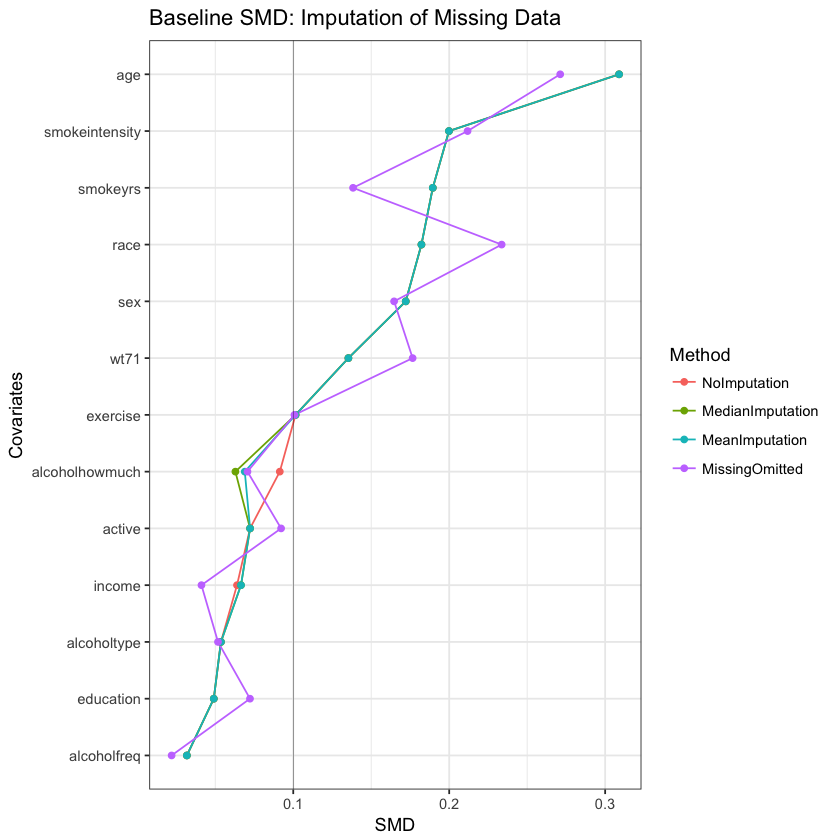

In [445]:
#pull the information from each of the tables and set it into a dataframe using ExtractSmd()
#pull the covariate names from any of the tables, we'll use the unmatchedtableone
#assign all other table information for each imputation method
initial_smdPlot = data.frame(Covariates = names(ExtractSmd(unmatchedTableOne.df2)),
                      NoImputation = ExtractSmd(unmatchedTableOne.df2),
                      MedianImputation = ExtractSmd(unmatchedTableOne.med),
                      MeanImputation = ExtractSmd(unmatchedTableOne.mean),
                      MissingOmitted = ExtractSmd(unmatchedTableOne.noNA))

#use the melt function to change/transform the data into something we can plot
#the melt function transfers data from wide to long format, and vice versa
#melt on our data, our IDs will be the covariates
#the variable names we'll call method and the value we'll call SMD
initial_smdPlotMelt = melt(data = initial_smdPlot,
                   id.vars = c("Covariates"),
                   variable.name = "Method",
                   value.name = "SMD")

#set the variable names and order them by what's in the unmatched data
#need to make sure all variables are characters, not numerics
initial_var.Names = as.character(initial_smdPlot$Covariates[order(initial_smdPlot$NoImputation)])

#set up the factors of the variables for plotting (pulls each var out of the list)
initial_smdPlotMelt$Covariates = factor(initial_smdPlotMelt$Covariates, levels=initial_var.Names)


#now we actually plot

#to plot in a jupyter notebook we set this
options(jupyter.plot_mimetypes = 'image/png')

#plot the SMD data, line plot, with points, and a horizontal line
#overlapping lines will show only one color
ggplot(data=initial_smdPlotMelt, mapping = aes(x = Covariates, y = SMD, group = Method, color = Method)) + 
    geom_line() + geom_point() + geom_hline(yintercept = 0.1, color = "black", size = 0.1) + 
    coord_flip() + theme_bw() + theme(legend.key = element_blank()) + 
    ggtitle("Baseline SMD: Imputation of Missing Data")

Overall, it would appear that median imputation performs slightly better than all others in general. We will continue with using median imputed missing data in our dataset going forward.  
  
  
We can see from this, that matching or weighting of some kind should provide better estimates for nearly all estimates, but especially for the characteristics pertaining to smoking, and demographic features. This tells us that our populations of quitters and nonquittersa have large differences between the intensity at which they smoke and for how long they've been smoking, also with large differences in age, race, sex, etc.

### Using logistic regression to estimate the propensity score, i.e. the propensity for an observed person to be treated 

We'll try out a few functional forms to see how we can best obtain covariate balance between treatment groups. We'll implement the following models, 

1) Matching on the propensity score (ps)   
2) Matchit PS Nearest Neighbor  
3) Matchit PS Nearest Neighbor with Caliper  
4) Weighted Matched (via PS)  
5) IPW (standardized)   

We will also implement these with and without interactions for comparison of the SMDs.


**Interaction Terms**  
  
Interaction terms were chosen as the following, `alcoholfreq*alcoholhowmuch + smokeintensity*smokeyrs + age*smokeyrs`. These were included as based on intuition, where there is likely an interaction between how much you drink/smoke and how long/often you drink/smoke, along with how old you are and how long you've been smoking for. Other interactions can surely be explored, including polynomial terms. I was not able to find a set of interaction terms that truly minimized by SMD, as we'll see shortly.

The summary models for the non-interaction models will not be shown, as these will only be used in the plot of the SMD as a visual aid in model building.

**Propesity Score**  
We'll use logistic regression to come up with the predicted probability of being assigned to treatment. Keep in mind that we do not care about statistical significance, confounding of our treatment and outcome can occur without statistical significance by our treatment variable.

In [542]:
#INTERACTIONS

#mirror our dataframe to a new one for this matching, psdf
psdf = dfmed.noNA

#setting up a propensity score model using logistic regression
#glm with family binomial and link logit
psModel = glm(qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
                     alcoholtype + wt71 + education + exercise + income +
                     race + sex + smokeintensity + smokeyrs + 
                     alcoholfreq*alcoholhowmuch + smokeintensity*smokeyrs + 
                     age*smokeyrs,
              family = binomial(link="logit"),
              data = psdf)

#predicted probabilities of being assigned
psdf$ps.qsmk = predict(psModel, type="response")

#predicted prob of not being assigned
psdf$nps.qsmk = 1 - psdf$ps.qsmk

#set a blank probability assignment (so we can both the ps and nps into one column)
psdf$pAssign = NA

#set the ps assignment for those who quit smoking
psdf$pAssign[psdf$qsmk == 1] = psdf$ps.qsmk[psdf$qsmk == 1]
#set the nps assignment for those who didn't quit smoking
psdf$pAssign[psdf$qsmk == 0] = psdf$nps.qsmk[psdf$qsmk == 0]

#check summary
summary(psModel)


###########################################################################################
#NO INTERACTIONS

#new dataframe
psdfn = dfmed.noNA

#setting up a propensity score model using logistic regression
psModeln = glm(qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
                      alcoholtype + wt71 + education + exercise + income +
                      race + sex + smokeintensity + smokeyrs,
               family = binomial(link="logit"),
               data = psdfn)

#predicted probabilities of being assigned
psdfn$ps.qsmk = predict(psModeln, type="response")

#predicted prob of not being assigned
psdfn$nps.qsmk = 1 - psdfn$ps.qsmk

#set a blank probability assignment (so we can both the ps and nps into one column)
psdfn$pAssign = NA

#set the ps assignment for those who quit smoking
psdfn$pAssign[psdfn$qsmk == 1] = psdfn$ps.qsmk[psdfn$qsmk == 1]

#set the nps assignment for those who didn't quit smoking
psdfn$pAssign[psdfn$qsmk == 0] = psdfn$nps.qsmk[psdfn$qsmk == 0]


Call:
glm(formula = qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
    alcoholtype + wt71 + education + exercise + income + race + 
    sex + smokeintensity + smokeyrs + alcoholfreq * alcoholhowmuch + 
    smokeintensity * smokeyrs + age * smokeyrs, family = binomial(link = "logit"), 
    data = psdf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3315  -0.8133  -0.6493   1.1317   2.4040  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -2.5941157  0.7569969  -3.427 0.000611 ***
active                      0.0627319  0.0932939   0.672 0.501322    
age                         0.0405463  0.0124744   3.250 0.001153 ** 
alcoholfreq                 0.0318710  0.0922336   0.346 0.729683    
alcoholhowmuch             -0.0237975  0.0442501  -0.538 0.590717    
alcoholtype                -0.0184598  0.0642935  -0.287 0.774022    
wt71                        0.0068009  0.0041831   1.626 0.103990    


**PS Matching (one-to-one matching with a caliper = 0.2)**  
One-to-one matching is a single match between the treatment and control group, whereas you can have 1:M matching, etc. A caliper gives a distance metric on how far apart the propensity scores can be from one another, this helps ensure that we dont have a match where the propensity scores really don't match (say a match of 0.5 to 0.75).  

In [543]:
#INTERACTIONS

#using the Matching package
#now match the propensity scores with a caliper distance of 0.2 * sd(logit(ps)) 
#and 1:1 matching where logit of ps is the match scale, log(ps/(1-ps))
ps_datamatch = Match(Tr = (psdf$qsmk == 1),
                     X = log(psdf$ps.qsmk/psdf$nps.qsmk),
                     M = 1, 
                     caliper=0.2, 
                     replace = F, 
                     ties = T,
                     version = "fast")

#pull out the matched data by their index as treated and control (given from Match) by rows
ps_Match = psdf[unlist(ps_datamatch[c("index.treated","index.control")]) , ]

#check the summary
summary(ps_Match)

###########################################################################################
#NO INTERACTIONS

#now match the propensity scores with a caliper distance of 0.2 * sd(logit(ps)) 
#and 1:1 matching where logit of ps is the match scale, log(ps/(1-ps))
ps_datamatchn = Match(Tr = (psdfn$qsmk == 1),
                      X = log(psdfn$ps.qsmk/psdfn$nps.qsmk),
                      M = 1, 
                      caliper = 0.2, 
                      replace = F,
                      ties = T,
                      version = "fast")

#pull out the matched data by their index as treated and control (given from Match) by rows
ps_Matchn = psdfn[unlist(ps_datamatchn[c("index.treated","index.control")]) , ]

      qsmk           id          active            age         alcoholfreq   
 Min.   :0.0   1001   :  1   Min.   :0.0000   Min.   :25.00   Min.   :0.000  
 1st Qu.:0.0   1004   :  1   1st Qu.:0.0000   1st Qu.:36.00   1st Qu.:1.000  
 Median :0.5   1006   :  1   Median :1.0000   Median :47.00   Median :2.000  
 Mean   :0.5   1008   :  1   Mean   :0.6715   Mean   :46.42   Mean   :1.929  
 3rd Qu.:1.0   1009   :  1   3rd Qu.:1.0000   3rd Qu.:56.00   3rd Qu.:3.000  
 Max.   :1.0   101    :  1   Max.   :2.0000   Max.   :74.00   Max.   :5.000  
               (Other):828                                                   
 alcoholhowmuch    alcoholtype      education        exercise    
 Min.   : 1.000   Min.   :1.000   Min.   :1.000   Min.   :0.000  
 1st Qu.: 2.000   1st Qu.:1.000   1st Qu.:2.000   1st Qu.:1.000  
 Median : 3.000   Median :3.000   Median :3.000   Median :1.000  
 Mean   : 3.158   Mean   :2.525   Mean   :2.784   Mean   :1.237  
 3rd Qu.: 4.000   3rd Qu.:4.000   3rd Qu.:3.00

In [544]:
#dimension of the propensity matched data
#we clearly lost a few samples due to matching
dim(ps_Match)

[1] 834  18

In [395]:
#INTERACTIONS

#CreateTableOne - matched data
ps1Matched = CreateTableOne(vars = include_covar, 
                            strata = "qsmk", 
                            data = ps_Match, 
                            test = F)

#print table
print(ps1Matched, smd = TRUE)

###########################################################################################
#NO INTERACTIONS

#CreateTableOne
ps1Matchedn = CreateTableOne(vars = include_covar, 
                             strata = "qsmk", 
                             data = ps_Matchn, 
                             test = F)

                            Stratified by qsmk
                             0             1             SMD   
  n                            417           417               
  active (mean (sd))          0.66 (0.65)   0.68 (0.66)   0.037
  age (mean (sd))            47.14 (12.23) 46.21 (12.26)  0.076
  alcoholfreq (mean (sd))     1.92 (1.36)   1.94 (1.32)   0.016
  alcoholhowmuch (mean (sd))  3.16 (3.05)   3.14 (2.23)   0.006
  alcoholtype (mean (sd))     2.61 (1.20)   2.53 (1.19)   0.068
  education (mean (sd))       2.82 (1.21)   2.76 (1.28)   0.048
  exercise (mean (sd))        1.25 (0.71)   1.24 (0.72)   0.020
  income (mean (sd))         18.02 (2.72)  18.10 (2.44)   0.031
  race (mean (sd))            0.08 (0.27)   0.09 (0.29)   0.034
  sex (mean (sd))             0.47 (0.50)   0.45 (0.50)   0.043
  smokeintensity (mean (sd)) 19.75 (11.45) 19.08 (12.22)  0.056
  smokeyrs (mean (sd))       27.38 (12.54) 26.54 (12.86)  0.066
  wt71 (mean (sd))           72.34 (14.99) 72.51 (16.19) 

**PS Matching - MatchIt**  

We'll run both methods of matching using the package `MatchIt`, using nearest neighbor with and without a caliper

In [547]:
#INTERACTIONS

#No Caliper

#copy the dataframe
dfmatchit = dfmed.noNA

#propensity score matching for the median imputed data
ps_matchit = matchit(qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
                            alcoholtype + wt71 + education + exercise + income +
                            race + sex + smokeintensity + smokeyrs  + 
                            alcoholfreq*alcoholhowmuch + smokeintensity*smokeyrs + 
                            age*smokeyrs,
                     method = "nearest", 
                     data = dfmatchit)

#set the matched data into a dataframe and check the summary
df_psm = match.data(ps_matchit)


#Caliper

#new df
dfmatchit1 = dfmed.noNA

#model
ps_matchit1 = matchit(qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
                             alcoholtype + wt71 + education + exercise + income +
                             race + sex + smokeintensity + smokeyrs  + 
                             alcoholfreq*alcoholhowmuch + smokeintensity*smokeyrs + 
                             age*smokeyrs,
                      method = "nearest", 
                      caliper = 0.2,
                      data = dfmatchit1)

#set the matched data into a dataframe
df_psm1 = match.data(ps_matchit1)


###########################################################################################
#NO INTERACTIONS

#No Caliper

#propensity score matching for the median imputed data
dfmatchitn = dfmed.noNA
ps_matchitn = matchit(qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
                             alcoholtype + wt71 + education + exercise + income +
                             race + sex + smokeintensity + smokeyrs,
                      method = "nearest", 
                      data = dfmatchitn)

df_psmn = match.data(ps_matchitn)


#Caliper

dfmatchit1n = dfmed.noNA
ps_matchit1n = matchit(qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
                              alcoholtype + wt71 + education + exercise + income +
                              race + sex + smokeintensity + smokeyrs,
                       method = "nearest", 
                       caliper = 0.2,
                       data = dfmatchit1n)

df_psm1n = match.data(ps_matchit1n)

In [410]:
#check dimensions of the no caliper matchit
dim(df_psm)
#check dimensions of the caliper matchit
dim(df_psm1)

[1] 856  17

[1] 836  17

In [444]:
#CreateTableOne - matchit without caliper
psMatchIt = CreateTableOne(vars = include_covar, 
                           strata = "qsmk", 
                           data = df_psm, 
                           test = F)
#print table
print(psMatchIt, smd = TRUE)


#CreateTableOne - matchit with caliper
psMatchIt1 = CreateTableOne(vars = include_covar, 
                            strata = "qsmk", 
                            data = df_psm1, 
                            test = F)
#print table
print(psMatchIt1, smd = TRUE)


###########################################################################################
#NO INTERACTIONS

#CreateTableOne - matchit without caliper
psMatchItn = CreateTableOne(vars = include_covar, 
                            strata = "qsmk", 
                            data = df_psmn, 
                            test = F)

#CreateTableOne - matchitwith caliper
psMatchIt1n = CreateTableOne(vars = include_covar, 
                             strata = "qsmk", 
                             data = df_psm1n, 
                             test = F)

                            Stratified by qsmk
                             0             1             SMD   
  n                            428           428               
  active (mean (sd))          0.69 (0.66)   0.69 (0.66)  <0.001
  age (mean (sd))            47.51 (12.38) 46.70 (12.52)  0.065
  alcoholfreq (mean (sd))     1.92 (1.36)   1.95 (1.32)   0.021
  alcoholhowmuch (mean (sd))  3.09 (2.93)   3.13 (2.22)   0.014
  alcoholtype (mean (sd))     2.61 (1.20)   2.52 (1.20)   0.076
  education (mean (sd))       2.75 (1.25)   2.75 (1.28)   0.002
  exercise (mean (sd))        1.26 (0.72)   1.25 (0.72)   0.010
  income (mean (sd))         18.10 (2.70)  18.09 (2.45)   0.006
  race (mean (sd))            0.07 (0.26)   0.09 (0.28)   0.051
  sex (mean (sd))             0.46 (0.50)   0.45 (0.50)   0.028
  smokeintensity (mean (sd)) 19.91 (11.69) 18.79 (12.26)  0.093
  smokeyrs (mean (sd))       27.50 (12.52) 26.61 (13.03)  0.070
  wt71 (mean (sd))           71.93 (14.37) 72.63 (16.08) 

**Weighted Matching**  
Matching on the weights given by the inverse of the propensity score

In [558]:
#copy a new dataframe
wtmatch = dfmed.noNA

#setup the same propensity score we did earlier
psModel1 = glm(qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
                      alcoholtype + wt71 + education + exercise + income +
                      race + sex + smokeintensity + smokeyrs + 
                      alcoholfreq*alcoholhowmuch + smokeintensity*smokeyrs + 
                      age*smokeyrs,
               family = binomial(link="logit"),
               data = wtmatch)

#predicted probabilities of being assigned
wtmatch$ps.qsmk = predict(psModel1, type="response")

#predicted prob of not being assigned
wtmatch$nps.qsmk = 1 - wtmatch$ps.qsmk

#set a blank probability assignment (so we can both the ps and nps into one column)
wtmatch$pAssign = NA

#set the ps assignment for those who quit smoking
wtmatch$pAssign[wtmatch$qsmk == 1] = wtmatch$ps.qsmk[wtmatch$qsmk == 1]

#set the nps assignment for those who didn't quit smoking
wtmatch$pAssign[wtmatch$qsmk == 0] = wtmatch$nps.qsmk[wtmatch$qsmk == 0]

#take a minimum factor of the two (we'll use this for stabilized IPTW)
#setting up the matching weight
wtmatch$pMin = pmin(wtmatch$ps.qsmk, wtmatch$nps.qsmk)

#set up the matched weight (which we'll use in IPTW) for lowest probability over actual prob
#weighted data assinging the matched weight
wtmatch$mw = wtmatch$pMin/wtmatch$pAssign

#setup the data with svydesign package
wtmatch_ps = svydesign(ids = ~ 1, data = wtmatch, weights = ~ mw)

###########################################################################################
#NO INTERACTIONS

#copy the dataframe
wtmatchn = dfmed.noNA
psModel1n = glm(qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
                       alcoholtype + wt71 + education + exercise + income +
                       race + sex + smokeintensity + smokeyrs,
              family = binomial(link="logit"),
              data = wtmatchn)

#predicted probabilities of being assigned
wtmatchn$ps.qsmk = predict(psModel1n, type="response")

#predicted prob of not being assigned
wtmatchn$nps.qsmk = 1 - wtmatchn$ps.qsmk

#set a blank probability assignment (so we can both the ps and nps into one column)
wtmatchn$pAssign = NA

#set the ps assignment for those who quit smoking
wtmatchn$pAssign[wtmatchn$qsmk == 1] = wtmatchn$ps.qsmk[wtmatchn$qsmk == 1]

#set the nps assignment for those who didn't quit smoking
wtmatchn$pAssign[wtmatchn$qsmk == 0] = wtmatchn$nps.qsmk[wtmatchn$qsmk == 0]

#take a minimum factor
wtmatchn$pMin = pmin(wtmatchn$ps.qsmk, wtmatchn$nps.qsmk)

#set up the matched weight
wtmatchn$mw = wtmatchn$pMin / wtmatchn$pAssign

#setup the data with svydesign package
wtmatch_psn = svydesign(ids = ~ 1, 
                        data = wtmatchn, 
                        weights = ~ mw)

In [559]:
#CreateTableOne - weighted matching
wtmatchTableOne = svyCreateTableOne(vars = include_covar, 
                                    strata="qsmk", 
                                    data=wtmatch_ps, 
                                    test=F)
print(wtmatchTableOne, smd=T)
addmargins(table(ExtractSmd(wtmatchTableOne) > 0.1))

###########################################################################################
#NO INTERACTIONS

#now set up a CreateTableOne - weighted matching
wtmatchTableOnen = svyCreateTableOne(vars = include_covar, 
                                     strata="qsmk", 
                                     data=wtmatch_psn, 
                                     test=F)

                            Stratified by qsmk
                             0              1              SMD   
  n                          424.95         422.33               
  active (mean (sd))           0.69 (0.66)    0.68 (0.66)   0.004
  age (mean (sd))             46.53 (12.56)  46.49 (12.43)  0.003
  alcoholfreq (mean (sd))      1.95 (1.34)    1.95 (1.32)   0.004
  alcoholhowmuch (mean (sd))   3.10 (2.24)    3.13 (2.19)   0.014
  alcoholtype (mean (sd))      2.54 (1.21)    2.53 (1.20)   0.011
  education (mean (sd))        2.77 (1.22)    2.75 (1.28)   0.017
  exercise (mean (sd))         1.24 (0.73)    1.24 (0.72)   0.008
  income (mean (sd))          18.12 (2.60)   18.10 (2.45)   0.011
  race (mean (sd))             0.09 (0.29)    0.09 (0.29)   0.003
  sex (mean (sd))              0.44 (0.50)    0.45 (0.50)   0.003
  smokeintensity (mean (sd))  18.99 (10.81)  18.94 (12.25)  0.004
  smokeyrs (mean (sd))        26.67 (12.65)  26.64 (12.98)  0.002
  wt71 (mean (sd))           


FALSE   Sum 
   13    13 

**IPW**  
Inverse Probability Weighting of the Treatment: 1/PS

In [560]:
#INTERACTIONS

#copy df
iptwdf = dfmed.noNA

#setup the ipw model with 1=numerator/denomenator=regressed probabilities
iptw_model = ipwpoint(exposure = qsmk, family="binomial", link="logit", numerator=~1,
                      denominator = ~ active + age + alcoholfreq + alcoholhowmuch + 
                                      alcoholtype + wt71 + education + exercise + income +
                                      race + sex + smokeintensity + smokeyrs  + 
                                      alcoholfreq*alcoholhowmuch + smokeintensity*smokeyrs + 
                                      age*smokeyrs, 
                      data=iptwdf)

#check summaries
summary(iptw_model$den.mod)

###########################################################################################
#NO INTERACTIONS

#copy df
iptwdfn = dfmed.noNA

#ipw model
iptw_modeln = ipwpoint(exposure = qsmk, family="binomial", link="logit", numerator=~1,
                       denominator = ~ active + age + alcoholfreq + alcoholhowmuch + 
                                       alcoholtype + wt71 + education + exercise + income +
                                       race + sex + smokeintensity + smokeyrs, 
                       data=iptwdfn)


Call:
glm(formula = qsmk ~ active + age + alcoholfreq + alcoholhowmuch + 
    alcoholtype + wt71 + education + exercise + income + race + 
    sex + smokeintensity + smokeyrs + alcoholfreq * alcoholhowmuch + 
    smokeintensity * smokeyrs + age * smokeyrs, family = "logit", 
    data = iptwdf, na.action = na.fail)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3315  -0.8133  -0.6493   1.1317   2.4040  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -2.5941157  0.7569969  -3.427 0.000611 ***
active                      0.0627319  0.0932939   0.672 0.501322    
age                         0.0405463  0.0124744   3.250 0.001153 ** 
alcoholfreq                 0.0318710  0.0922336   0.346 0.729683    
alcoholhowmuch             -0.0237975  0.0442501  -0.538 0.590717    
alcoholtype                -0.0184598  0.0642935  -0.287 0.774022    
wt71                        0.0068009  0.0041831   1.626 0.10399

In [561]:
#INTERACTIONS

#assign the ipw weights as stipw in our df iptwdf
iptwdf$stipw = iptw_model$ipw.weights

#setup the IPW model with the svydesign package
ipw_matched = svydesign(ids = ~ 1, 
                        data = iptwdf, 
                        weights = ~ stipw)

###########################################################################################
#NO INTERACTIONS

#assign the ipw weights
iptwdfn$stipw = iptw_modeln$ipw.weights

#setup the IPW model with svydesign package
ipw_matchedn = svydesign(ids = ~ 1, 
                         data = iptwdfn, 
                         weights = ~ stipw)

In [562]:
#INTERACTIONS

#CreateTableOne - IPW
ipwTableOne = svyCreateTableOne(vars = include_covar, 
                                strata="qsmk", 
                                data=ipw_matched, 
                                test=F)
print(ipwTableOne, smd=T)
addmargins(table(ExtractSmd(ipwTableOne) > 0.1))

###########################################################################################
#NO INTERACTIONS

ipwTableOnen = svyCreateTableOne(vars = include_covar, 
                                 strata="qsmk", 
                                 data=ipw_matchedn, 
                                 test=F)

                            Stratified by qsmk
                             0               1              SMD   
  n                          1200.61         425.06               
  active (mean (sd))            0.65 (0.65)    0.66 (0.64)   0.016
  age (mean (sd))              43.89 (12.19)  44.04 (12.08)  0.012
  alcoholfreq (mean (sd))       1.92 (1.31)    1.92 (1.32)  <0.001
  alcoholhowmuch (mean (sd))    3.23 (2.62)    3.15 (2.15)   0.037
  alcoholtype (mean (sd))       2.48 (1.21)    2.52 (1.20)   0.032
  education (mean (sd))         2.71 (1.17)    2.74 (1.23)   0.027
  exercise (mean (sd))          1.19 (0.74)    1.19 (0.71)   0.004
  income (mean (sd))           17.97 (2.66)   18.04 (2.46)   0.028
  race (mean (sd))              0.13 (0.34)    0.14 (0.34)   0.012
  sex (mean (sd))               0.51 (0.50)    0.51 (0.50)   0.004
  smokeintensity (mean (sd))   20.59 (11.43)  20.35 (12.59)  0.020
  smokeyrs (mean (sd))         24.88 (12.10)  24.96 (12.40)  0.006
  wt71 (mean (s


FALSE   Sum 
   13    13 

Now that we have each of these set up, lets take a look at how they've performed

**Final SMD**  
  
We'll look at the SMD for the unmatched and IPW only, including all the other model results will result in too large a table, the graph of SMD will explain the same information for all models

In [550]:
#combine the tables into a vector that can plot using cbind()
combotbl = cbind(print(ipwTableOne, printToggle=F),
                 print(unmatchedTableOne.med, printToggle=F))

#bind the group names, and repeat twice
combotbl = rbind(Group = rep(c("No Quit Smk", "Quit Smk"), 2), combotbl)

#bind the column names for the methods
colnames(combotbl) = c("Unmatched", "", "IPW", "")

#print the combine table
print(combotbl, quote=F, smd=T)

                           Unmatched                      IPW          
Group                      No Quit Smk     Quit Smk       No Quit Smk  
n                          1200.61         425.06          1201        
active (mean (sd))            0.65 (0.65)    0.66 (0.64)   0.64 (0.65) 
age (mean (sd))              43.89 (12.19)  44.04 (12.08) 42.92 (11.89)
alcoholfreq (mean (sd))       1.92 (1.31)    1.92 (1.32)   1.91 (1.30) 
alcoholhowmuch (mean (sd))    3.23 (2.62)    3.15 (2.15)   3.29 (2.74) 
alcoholtype (mean (sd))       2.48 (1.21)    2.52 (1.20)   2.46 (1.21) 
education (mean (sd))         2.71 (1.17)    2.74 (1.23)   2.69 (1.15) 
exercise (mean (sd))          1.19 (0.74)    1.19 (0.71)   1.18 (0.75) 
income (mean (sd))           17.97 (2.66)   18.04 (2.46)  17.92 (2.67) 
race (mean (sd))              0.13 (0.34)    0.14 (0.34)   0.15 (0.35) 
sex (mean (sd))               0.51 (0.50)    0.51 (0.50)   0.53 (0.50) 
smokeintensity (mean (sd))   20.59 (11.43)  20.35 (12.59) 21.18 

**Plotting the SMD for all methods with and without interactions for comparison**

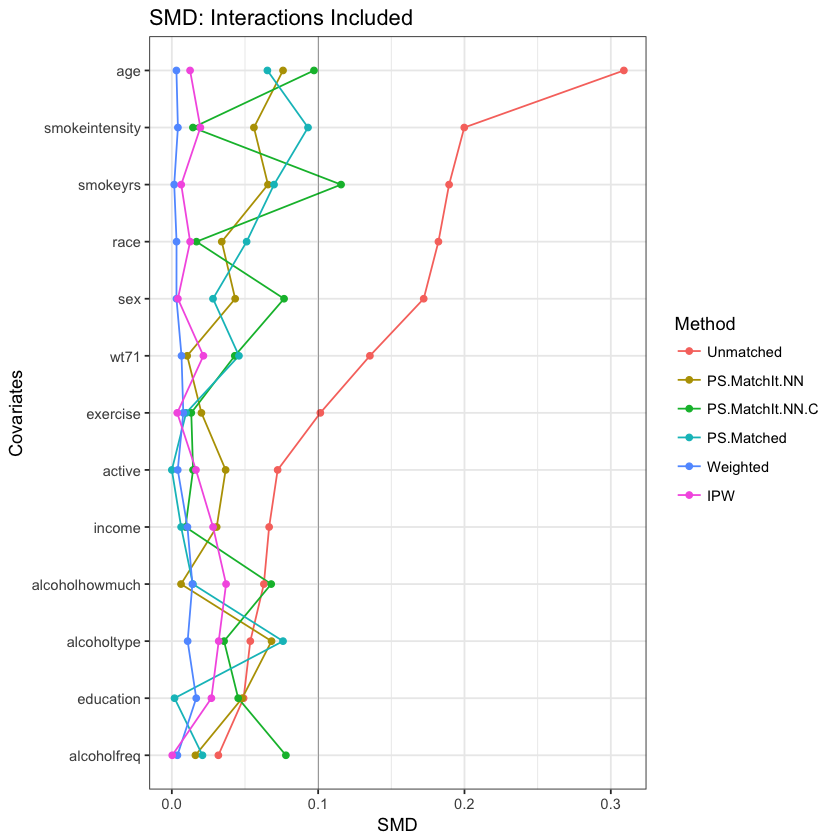

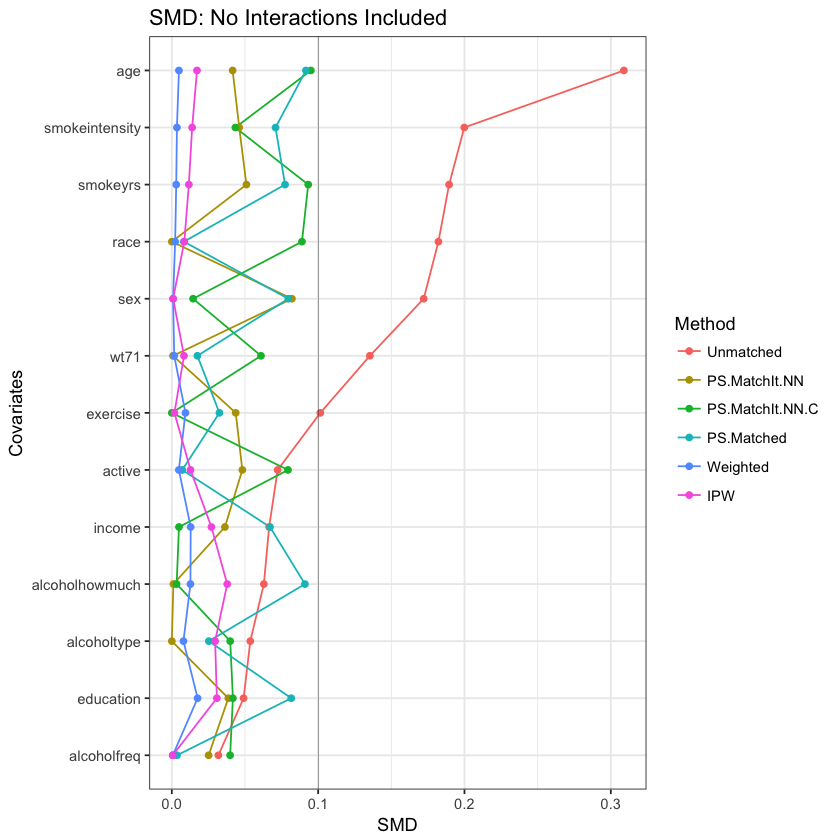

In [396]:
#INTERACTIONS

#pull the information from each of the tables and set it into a dataframe using extractsmd()
smdPlot = data.frame(Covariates = names(ExtractSmd(unmatchedTableOne.med)),
                     Unmatched = ExtractSmd(unmatchedTableOne.med),
                     PS.MatchIt.NN = ExtractSmd(ps1Matched),
                     PS.MatchIt.NN.C = ExtractSmd(psMatchIt1),
                     PS.Matched = ExtractSmd(psMatchIt),
                     Weighted = ExtractSmd(wtmatchTableOne),
                     IPW = ExtractSmd(ipwTableOne))

#use the melt function to change/transform the data into something we can plot
#melt is the same function you use to transform from wide to long formats (longitudinal data)
smdPlotMelt = melt(data = smdPlot,
                   id.vars = c("Covariates"),
                   variable.name = "Method",
                   value.name = "SMD")

#set the variable names and order them by what's in the unmatched data (defined in changePlt)
var.Names = as.character(smdPlot$Covariates[order(smdPlot$Unmatched)])

#set up the factors of the variables for plotting (pulls each var out of the list)
smdPlotMelt$Covariates = factor(smdPlotMelt$Covariates, levels=var.Names)

#plot
options(jupyter.plot_mimetypes = 'image/png')
ggplot(data=smdPlotMelt, mapping = aes(x = Covariates, y = SMD, group = Method, color = Method)) + 
    geom_line() + geom_point() + geom_hline(yintercept = 0.1, color = "black", size = 0.1) + 
    coord_flip() + theme_bw() + theme(legend.key = element_blank()) + 
    ggtitle("SMD: Interactions Included")

###########################################################################################
#NO INTERACTIONS

#pull the information from each of the tables and set it into a dataframe using extractsmd()
smdPlotn = data.frame(Covariates = names(ExtractSmd(unmatchedTableOne.med)),
                      Unmatched = ExtractSmd(unmatchedTableOne.med),
                      PS.MatchIt.NN = ExtractSmd(ps1Matchedn),
                      PS.MatchIt.NN.C = ExtractSmd(psMatchIt1n),                      
                      PS.Matched = ExtractSmd(psMatchItn),
                      Weighted = ExtractSmd(wtmatchTableOnen),
                      IPW = ExtractSmd(ipwTableOnen))

#use the melt function to change/transform the data into something we can plot
#melt is the same function you use to transform from wide to long formats (longitudinal data)
smdPlotMeltn = melt(data = smdPlotn,
                   id.vars = c("Covariates"),
                   variable.name = "Method",
                   value.name = "SMD")

#set the variable names and order them by what's in the unmatched data (defined in changePlt)
var.Namesn = as.character(smdPlotn$Covariates[order(smdPlotn$Unmatched)])

#set up the factors of the variables for plotting (pulls each var out of the list)
smdPlotMeltn$Covariates = factor(smdPlotMeltn$Covariates, levels=var.Namesn)

#plot
options(jupyter.plot_mimetypes = 'image/png')
ggplot(data=smdPlotMeltn, mapping = aes(x = Covariates, y = SMD, group = Method, color = Method)) + 
    geom_line() + geom_point() + geom_hline(yintercept = 0.1, color = "black", size = 0.1) + 
    coord_flip() + theme_bw() + theme(legend.key = element_blank()) + 
    ggtitle("SMD: No Interactions Included")


### Assessing common support and region of weights   
  
Interaction terms should be further explored especially for the PS matching techniques, IPW and Weighted Matching look okay.  
  
Before we make a decision on which is best to use in terms of SMD, we will check the common support of the propensity score along with the matched regions from MatchIt and the region of weights for the weighting methods.

In [224]:
#setup labels before hand for our plots
labelsCS = paste("Quite Smoking:", c("Yes", "No"))

**Common Support of the Propensity Score**

In [551]:
#pull out the propensity score for the matched data
ps1pred = data.frame(ps_score = predict(psModel, type="response"),
                     qsmk = psModel$model$qsmk)

#create a summary of the propensity score (to plot in the corner of histogram)
#do this for those who quit smoking (summary: min max quartiles)
smy.ps1pred1 = summary(ps1pred$ps_score[ps1pred$qsmk==1])

#paste the names in teh summary and format the results to 2 digits
#collapse the information by the escape character \n for new line
summ.smy.ps1pred1 = paste(names(smy.ps1pred1), format(smy.ps1pred1, digits=2), collapse="\n ")

#set the annotated information into a dataframe, and attach the correct label
#x and y are the plotting margins, we'll specify them again later
ann_ps1pred1 = data.frame(x=0.6, y=75, lab = summ.smy.ps1pred1,
                        qsmk = factor(labelsCS[1], levels=c(labelsCS[1], labelsCS[2])))

#check that these look right
summ.smy.ps1pred1; ann_ps1pred1

#create a summary of those who didn't quit smoking (summary: min max quartiles)
smy.ps1pred0 = summary(ps1pred$ps_score[ps1pred$qsmk==0])

#pasting the information from the summary, with digits set at 2
summ.smy.ps1pred0 = paste(names(smy.ps1pred0), format(smy.ps1pred0, digits=2), collapse="\n ")

#set the annotated information into a dataframe
ann_ps1pred0 = data.frame(x=0.6, y=75, lab = summ.smy.ps1pred0,
                        qsmk = factor(labelsCS[2], levels=c(labelsCS[1], labelsCS[2])))

#check that these look right
summ.smy.ps1pred0; ann_ps1pred0

#combine the annotated information into a single data frame, we'll use this to plot
ps1pred_total = rbind(ann_ps1pred1, ann_ps1pred0)

#check to make sure this is correct
ps1pred_total

[1] "Min. 0.056\n 1st Qu. 0.229\n Median 0.292\n Mean 0.307\n 3rd Qu. 0.377\n Max. 0.754"

x,y,lab,qsmk
0.6,75,Min. 0.056 1st Qu. 0.229 Median 0.292 Mean 0.307 3rd Qu. 0.377 Max. 0.754,Quite Smoking: Yes


[1] "Min. 0.032\n 1st Qu. 0.171\n Median 0.237\n Mean 0.247\n 3rd Qu. 0.312\n Max. 0.588"

x,y,lab,qsmk
0.6,75,Min. 0.032 1st Qu. 0.171 Median 0.237 Mean 0.247 3rd Qu. 0.312 Max. 0.588,Quite Smoking: No


x,y,lab,qsmk
0.6,75,Min. 0.056 1st Qu. 0.229 Median 0.292 Mean 0.307 3rd Qu. 0.377 Max. 0.754,Quite Smoking: Yes
0.6,75,Min. 0.032 1st Qu. 0.171 Median 0.237 Mean 0.247 3rd Qu. 0.312 Max. 0.588,Quite Smoking: No


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


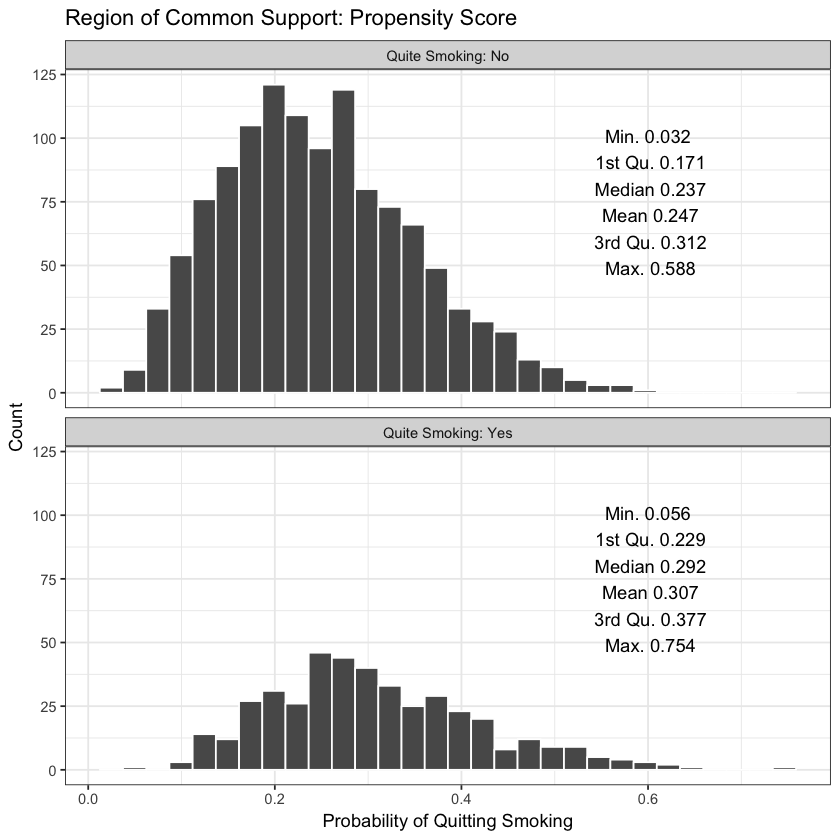

In [501]:
#plot from the dataset itself using the pipe function %>%
#we mutate the data so that people with qsmk==1 get a label of quit smoking, else no quit smk
#plot the propensity score as a histogram
#use facet_wrap to plot separate the histograms for smoking status
#use geom_text to add the summary information about the PS to the corner of the plot
ps1pred %>%
  mutate(qsmk = ifelse(qsmk==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x = ps_score)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~qsmk, nrow=2, ncol=1) + 
  xlab("Probability of Quitting Smoking") + 
  ylab("Count") + 
  ggtitle("Region of Common Support: Propensity Score") + 
  geom_text(data = ps1pred_total, aes(x=0.6, y=75, label=lab, group=NULL)) + 
  theme_bw()

**MatchIt - No caliper distance**

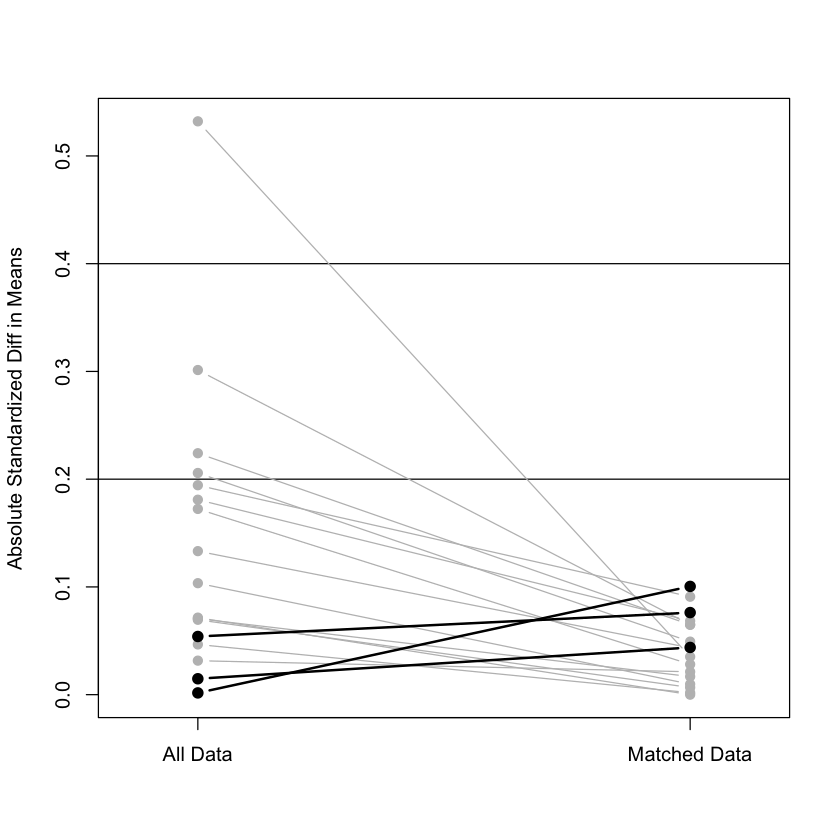

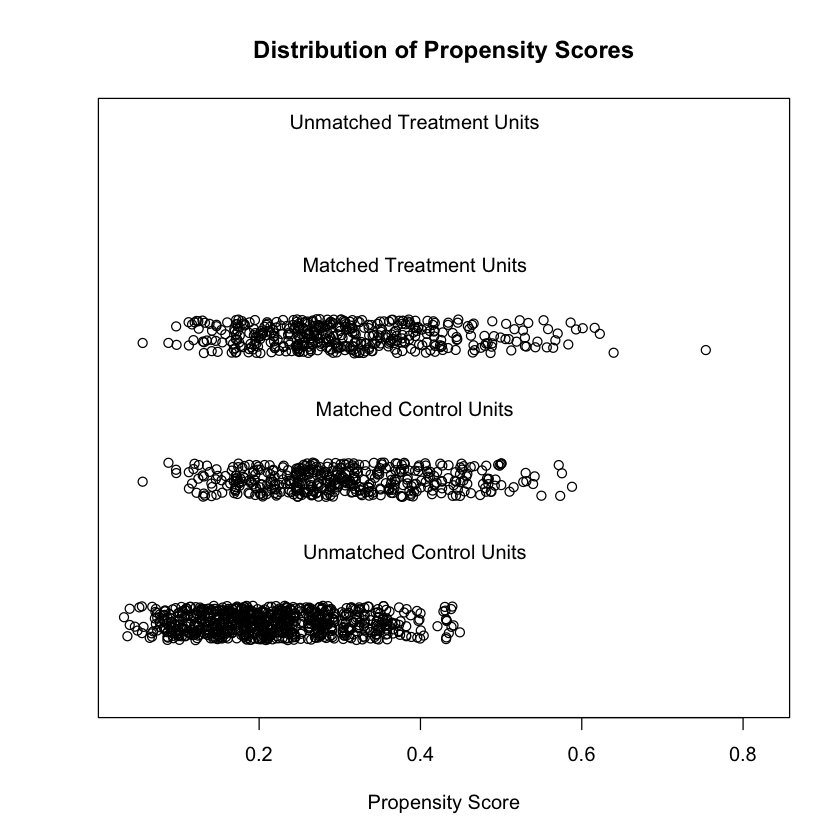

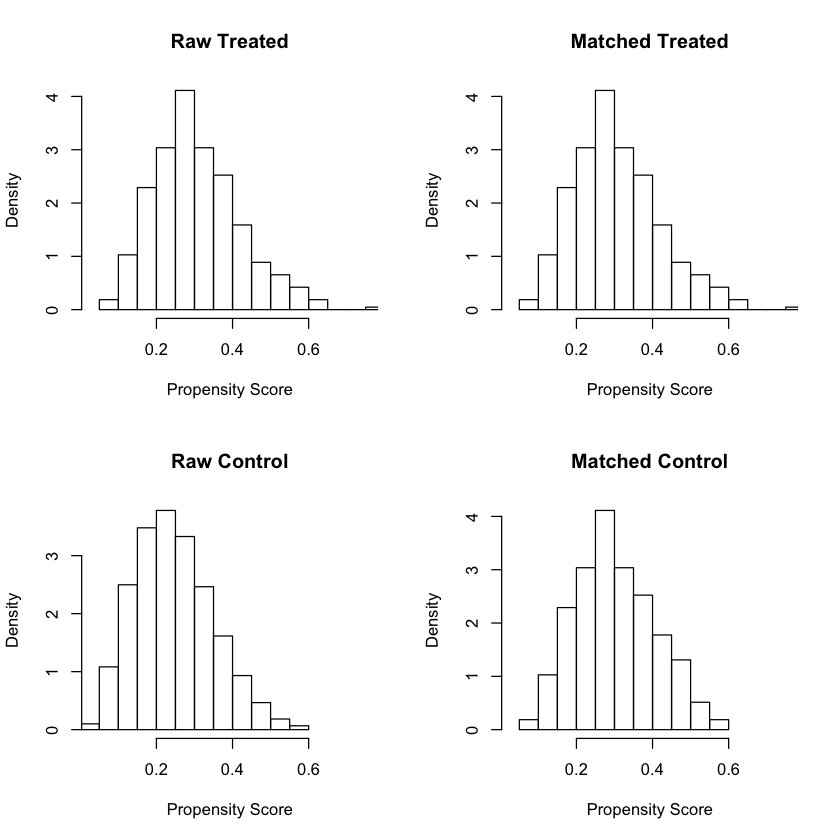

In [552]:
#summary of the data
plot(summary(ps_matchit, standardize=T), interactive=F)

#general jitter plot
plot(ps_matchit, type="jitter", interactive=F)

#general histogram plot
plot(ps_matchit, type="hist")

**MatchIt - With caliper distance**

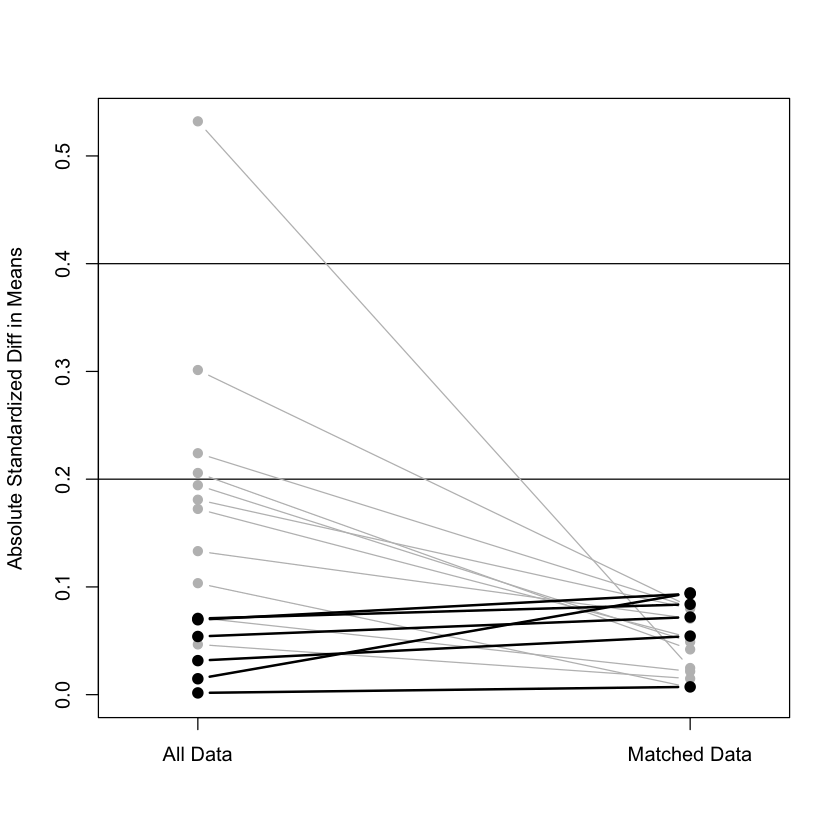

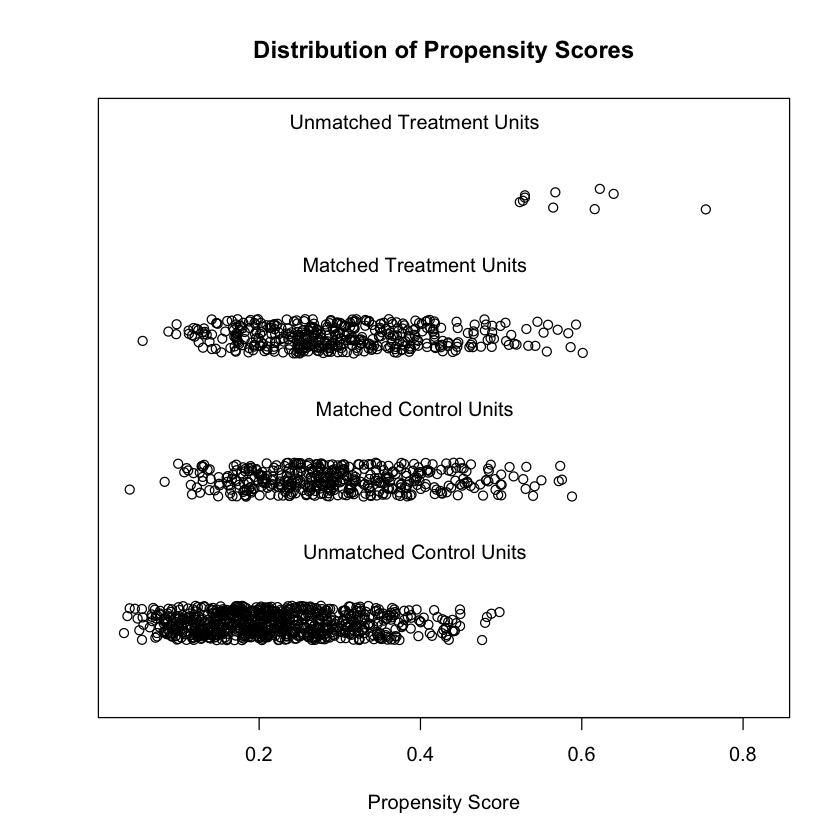

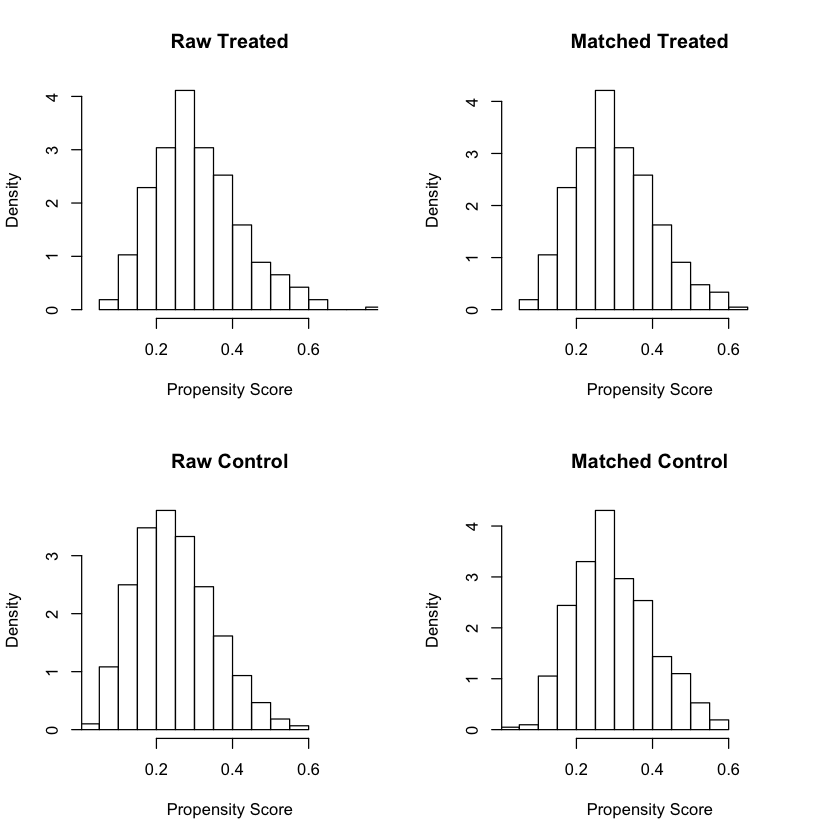

In [553]:
#summary of the data
plot(summary(ps_matchit1, standardize=T), interactive=F)

#general jitter plot
plot(ps_matchit1, type="jitter", interactive=F)

#general histogram plot
plot(ps_matchit1, type="hist")

**Graph of the Weighted Matching weights**

In [554]:
#weights for those who quit smoking (summary: min max quartiles)
#pull the weight out (weight = wtmatch)
#pasting the summary information and set the annotations into the dataframe
wtm1 = summary(wtmatch$mw[wtmatch$qsmk==1])
wtm1.1 = paste(names(wtm1), format(wtm1, digits=2), collapse="\n ")
ann_wtm1 = data.frame(x=0.75, y=250, lab = wtm1.1,
                        qsmk = factor(labelsCS[1], levels=c(labelsCS[1], labelsCS[2])))
#check the dataframe
wtm1.1; ann_wtm1


#weights for those who didnt quit smoking (summary: min max quartiles)
#pasting the summary information
#setting the annotations into the dataframe
wtm0 = summary(wtmatch$mw[wtmatch$qsmk==0])
wtm0.0 = paste(names(wtm0), format(wtm0, digits=2), collapse="\n ")
ann_wtm0 = data.frame(x=0.75, y=250, lab = wtm0.0,
                        qsmk = factor(labelsCS[2], levels=c(labelsCS[1], labelsCS[2])))
#check the dataframe
wtm0.0; ann_wtm0

#bind the annotated summaries for the weights where qsmk==1 and qsmk==0
#check the dataframe
wtm_total = rbind(ann_wtm1, ann_wtm0); wtm_total

#ipwplot(weights = as.numeric(wtmatch$mw), logscale=F, main="Stabilized Weights")

[1] "Min. 0.33\n 1st Qu. 1.00\n Median 1.00\n Mean 0.99\n 3rd Qu. 1.00\n Max. 1.00"

x,y,lab,qsmk
0.75,250,Min. 0.33 1st Qu. 1.00 Median 1.00 Mean 0.99 3rd Qu. 1.00 Max. 1.00,Quite Smoking: Yes


[1] "Min. 0.034\n 1st Qu. 0.206\n Median 0.310\n Mean 0.354\n 3rd Qu. 0.455\n Max. 1.000"

x,y,lab,qsmk
0.75,250,Min. 0.034 1st Qu. 0.206 Median 0.310 Mean 0.354 3rd Qu. 0.455 Max. 1.000,Quite Smoking: No


x,y,lab,qsmk
0.75,250,Min. 0.33 1st Qu. 1.00 Median 1.00 Mean 0.99 3rd Qu. 1.00 Max. 1.00,Quite Smoking: Yes
0.75,250,Min. 0.034 1st Qu. 0.206 Median 0.310 Mean 0.354 3rd Qu. 0.455 Max. 1.000,Quite Smoking: No


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


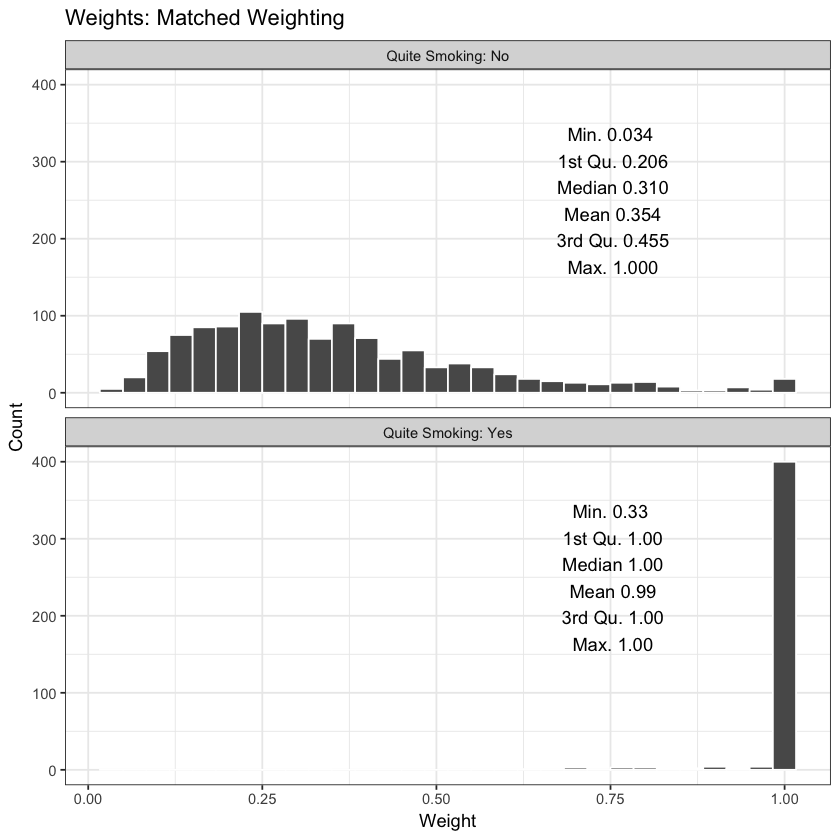

In [508]:
#plot from the dataset itself using the pipe function %>%
#we mutate the data so that people with qsmk==1 get a label of quit smoking, else no quit smk
#plot the weight as a histogram
#use facet_wrap to plot separate the histograms for smoking status
#use geom_text to add the summary information about the weight to the corner of the plot
wtmatch %>%
  mutate(qsmk = ifelse(qsmk==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x = mw)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~qsmk, nrow=2, ncol=1) + 
  xlab("Weight") + 
  ylab("Count") + 
  ggtitle("Weights: Matched Weighting") + 
  geom_text(data = wtm_total, aes(x=0.75, y=250, label=lab, group=NULL)) +
  theme_bw()

We can clearly see that the matched weights are not similar between the groups, this may not be the best model to use overall, however we'll assess how it performs in a regression shortly.

**Graph of IPW**

In [563]:
#weights for those who quit smoking (summary: min max quartiles)
#pull the weights from the data frame (weights = stipw)
#paste the summary information and set the annotations into a dataframe
ipw1 = summary(iptwdf$stipw[iptwdf$qsmk==1])
ipw1.1 = paste(names(ipw1), format(ipw1, digits=2), collapse="\n ")
ann_ipw1 = data.frame(x=3.5, y=300, lab = ipw1.1,
                        qsmk = factor(labelsCS[1], levels=c(labelsCS[1], labelsCS[2])))
#check the data
ipw1.1; ann_ipw1


#weights for those who didnt quit smoking (summary: min max quartiles)
ipw0 = summary(iptwdf$stipw[iptwdf$qsmk==0])
ipw0.0 = paste(names(ipw0), format(ipw0, digits=2), collapse="\n ")
ann_ipw0 = data.frame(x=3.5, y=300, lab = ipw0.0,
                        qsmk = factor(labelsCS[2], levels=c(labelsCS[1], labelsCS[2])))
#check the data
ipw0.0; ann_ipw0

#bind the annotated summaries for the weights where qsmk==1 and qsmk==0
ipw_total = rbind(ann_ipw1, ann_ipw0); ipw_total

#ipwplot(weights = as.numeric(iptwdf$stipw), logscale=F, main="Stabilized Weights")

[1] "Min. 0.35\n 1st Qu. 0.70\n Median 0.90\n Mean 0.99\n 3rd Qu. 1.15\n Max. 4.73"

x,y,lab,qsmk
3.5,300,Min. 0.35 1st Qu. 0.70 Median 0.90 Mean 0.99 3rd Qu. 1.15 Max. 4.73,Quite Smoking: Yes


[1] "Min. 0.76\n 1st Qu. 0.89\n Median 0.97\n Mean 1.00\n 3rd Qu. 1.07\n Max. 1.79"

x,y,lab,qsmk
3.5,300,Min. 0.76 1st Qu. 0.89 Median 0.97 Mean 1.00 3rd Qu. 1.07 Max. 1.79,Quite Smoking: No


x,y,lab,qsmk
3.5,300,Min. 0.35 1st Qu. 0.70 Median 0.90 Mean 0.99 3rd Qu. 1.15 Max. 4.73,Quite Smoking: Yes
3.5,300,Min. 0.76 1st Qu. 0.89 Median 0.97 Mean 1.00 3rd Qu. 1.07 Max. 1.79,Quite Smoking: No


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


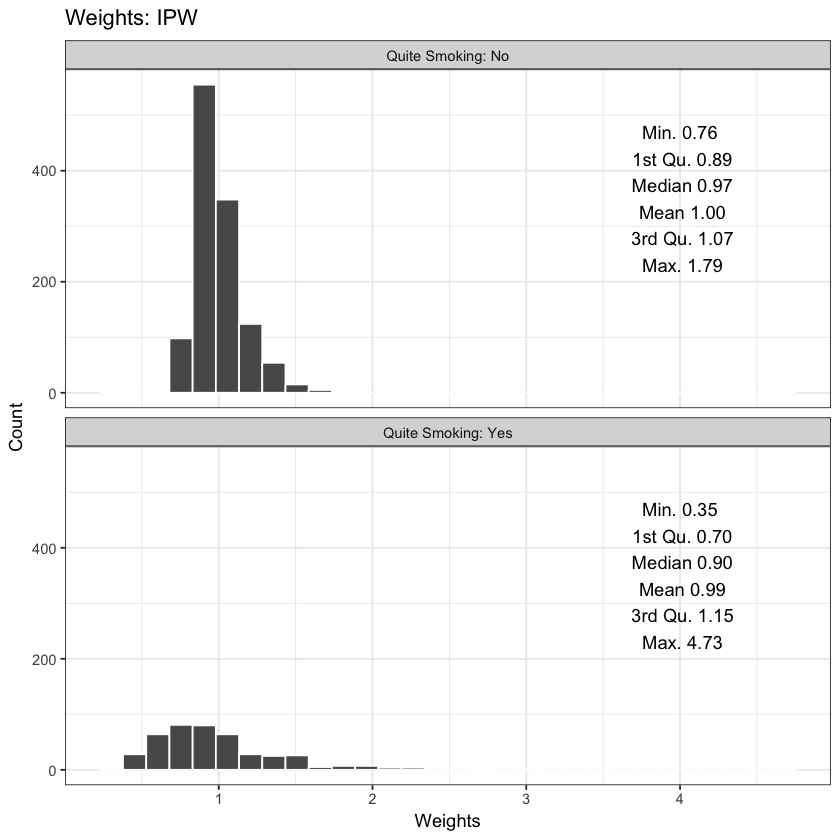

In [512]:
#plot from the dataset itself using the pipe function %>%
#we mutate the data so that people with qsmk==1 get a label of quit smoking, else no quit smk
#plot the weight as a histogram
#use facet_wrap to plot separate the histograms for smoking status
#use geom_text to add the summary information about the weight to the corner of the plot
iptwdf %>%
  mutate(qsmk = ifelse(qsmk==1, labelsCS[1], labelsCS[2])) %>%
  ggplot(aes(x = stipw)) + 
  geom_histogram(color = "white") + 
  facet_wrap(~qsmk, nrow=2, ncol=1) + 
  xlab("Weights") + 
  ylab("Count") + 
  ggtitle("Weights: IPW") + 
  geom_text(data = ipw_total, aes(x=4, y=350, label=lab, group=NULL)) +
  theme_bw()

These weights look a lot more balance, and we don't have any seriously high or low weights to be worried about. Overall this is a good model.

### Estimate the outcome

Merge the models back with the original dataframe and perform regressions to determine the average treatment effect. We will run the following regressions,

1) Matching on the propensity score (ps)   
2) Matchit PS Nearest Neighbor  
3) Matchit PS Nearest Neighbor with Caliper  
4) Weighted Matched (via PS)  
5) IPW (standardized)   
6) Regression adjusted for PS (continuous adjustment)  
7) Regression adjusted for PS (decile adjustment)  
8) Multivariate Adjustment (for comparison)  
9) Crude Model (for comparison)

**Regression with Matched PS**

In [424]:
#merge data for ps matched data
totaldf_psM = merge(df1, ps_Match, by="id")

#perform regression
psM_rg = glm(wt82_71 ~ qsmk.y, data=totaldf_psM)

#output information
summary(psM_rg); confint(psM_rg)

[1] "id"                "seqn"              "qsmk.x"           
 [4] "death"             "yrdth"             "modth"            
 [7] "dadth"             "sbp"               "dbp"              
[10] "sex.x"             "age.x"             "race.x"           
[13] "income.x"          "marital"           "school"           
[16] "education.x"       "ht"                "wt71.x"           
[19] "wt82"              "wt82_71"           "birthplace"       
[22] "smokeintensity.x"  "smkintensity82_71" "smokeyrs.x"       
[25] "asthma"            "bronch"            "tb"               
[28] "hf"                "hbp"               "pepticulcer"      
[31] "colitis"           "hepatitis"         "chroniccough"     
[34] "hayfever"          "diabetes"          "polio"            
[37] "tumor"             "nervousbreak"      "alcoholpy"        
[40] "alcoholfreq.x"     "alcoholtype.x"     "alcoholhowmuch.x" 
[43] "pica"              "headache"          "otherpain"        
[46] "weakheart"         "allergies"         "nerves"           
[49] "lackpep"           "hbpmed"            "boweltrouble"     
[52] "wtloss"            "infection"         "active.x"         
[55] "exercise.x"        "birthcontrol"      "pregnancies"      
[58] "cholesterol"       "hightax82"         "price71"          
[61] "price82"           "tax71"             "tax82"            
[64] "price71_82"        "tax71_82"          "qsmk.y"           
[67] "active.y"          "age.y"             "alcoholfreq.y"    
[70] "alcoholhowmuch.y"  "alcoholtype.y"     "education.y"      
[73] "exercise.y"        "income.y"          "race.y"           
[76] "sex.y"             "smokeintensity.y"  "smokeyrs.y"       
[79] "wt71.y"            "ps.qsmk"           "nps.qsmk"         
[82] "pAssign"


Call:
glm(formula = wt82_71 ~ qsmk.y, data = totaldf_psM)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-31.431   -4.317    0.024    4.401   47.610  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.9287     0.4061   2.287   0.0225 *  
qsmk.y        3.6985     0.5765   6.415 2.42e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 65.97426)

    Null deviance: 54967  on 793  degrees of freedom
Residual deviance: 52252  on 792  degrees of freedom
  (40 observations deleted due to missingness)
AIC: 5583.5

Number of Fisher Scoring iterations: 2


Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),0.1327399,1.724712
qsmk.y,2.5685612,4.828504


**Regression with PS Matching using MatchIt - No Caliper**

In [567]:
#merge dataframe
totaldf_psMt = merge(df1, df_psm,by="id")

#regression
psMt_rg = glm(wt82_71 ~ qsmk.y , data=totaldf_psMt)

#output info
summary(psMt_rg); confint(psMt_rg)


Call:
glm(formula = wt82_71 ~ qsmk.y, data = totaldf_psMt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-30.243   -4.281    0.031    4.365   47.321  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.2170     0.3920   3.105  0.00197 ** 
qsmk.y        3.3080     0.5564   5.945 4.11e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 62.85124)

    Null deviance: 53131  on 811  degrees of freedom
Residual deviance: 50910  on 810  degrees of freedom
  (44 observations deleted due to missingness)
AIC: 5670.7

Number of Fisher Scoring iterations: 2


Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),0.448713,1.985357
qsmk.y,2.217435,4.398652


**Regression with PS Matching using MatchIt - Caliper = 0.2**

In [568]:
#merge data
totaldf_psMt1 = merge(df1, df_psm1,by="id")

#regression
psMt_rg1 = glm(wt82_71 ~ qsmk.y , data=totaldf_psMt1)

#output info
summary(psMt_rg1); confint(psMt_rg1)


Call:
glm(formula = wt82_71 ~ qsmk.y, data = totaldf_psMt1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-42.722   -4.205   -0.008    4.640   47.096  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.4420     0.4126   3.495    5e-04 ***
qsmk.y        3.2152     0.5865   5.482 5.64e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 68.26219)

    Null deviance: 56115  on 793  degrees of freedom
Residual deviance: 54064  on 792  degrees of freedom
  (42 observations deleted due to missingness)
AIC: 5610.6

Number of Fisher Scoring iterations: 2


Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),0.6333286,2.250649
qsmk.y,2.0657833,4.364630


**PS Stratified: Continuous and Deciles**

In [519]:
#merge data
psorig = merge(df1,psdf,by="id")

#define a stratum for the PS to take on deciles (as a vector)
strat = quantile(psorig$pAssign, probs=c(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9))

#set the stratums range of PS
strat1 = psorig$ps.qsmk <= strat[1]
strat2 = psorig$ps.qsmk > strat[1] & psorig$ps.qsmk <= strat[2]
strat3 = psorig$ps.qsmk > strat[2] & psorig$ps.qsmk <= strat[3]
strat4 = psorig$ps.qsmk > strat[3] & psorig$ps.qsmk <= strat[4]
strat5 = psorig$ps.qsmk > strat[4] & psorig$ps.qsmk <= strat[5]
strat6 = psorig$ps.qsmk > strat[5] & psorig$ps.qsmk <= strat[6]
strat7 = psorig$ps.qsmk > strat[6] & psorig$ps.qsmk <= strat[7]
strat8 = psorig$ps.qsmk > strat[7] & psorig$ps.qsmk <= strat[8]
strat9 = psorig$ps.qsmk > strat[8] & psorig$ps.qsmk <= strat[9]
strat10 = psorig$ps.qsmk > strat[9]

#setup of the a single variable to take on categorical values
psorig$stratvar = numeric(length(psorig$qsmk.y))

#assign the categorical values through a forloop
#for i = 1 until the max length of the dataset, assign values
for (i in 1:length(psorig$qsmk.y)) {
    if (strat1_[i]==T) {psorig$stratvar[i] = 1}
    else if (strat2[i]==T) {psorig$stratvar[i] = 2}
    else if (strat3[i]==T) {psorig$stratvar[i] = 3}
    else if (strat4[i]==T) {psorig$stratvar[i] = 4}
    else if (strat5[i]==T) {psorig$stratvar[i] = 5}
    else if (strat6[i]==T) {psorig$stratvar[i] = 6}
    else if (strat7[i]==T) {psorig$stratvar[i] = 7}
    else if (strat8[i]==T) {psorig$stratvar[i] = 8}
    else if (strat9[i]==T) {psorig$stratvar[i] = 9}
    else psorig$stratvar[i] = 10
}
    
#regression as continuous - this is done on the original dataset
#its a like a unique form of multivariate regression
#where the PS captures all the covariate information
strmodel = glm(wt82_71 ~ qsmk.y + ps.qsmk, data=psorig)
summary(strmodel); confint(strmodel)
    
#regression as deciles
strmodel1 = glm(wt82_71 ~ qsmk.y + as.factor(stratvar), data = psorig)
summary(strmodel1); confint(strmodel1)


Call:
glm(formula = wt82_71 ~ qsmk.y + ps.qsmk, data = psorig)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-43.048   -4.028   -0.020    4.235   47.637  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.5465     0.5095  10.886  < 2e-16 ***
qsmk.y        3.3949     0.4561   7.443 1.61e-13 ***
ps.qsmk     -14.4776     1.8589  -7.788 1.23e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 58.66001)

    Null deviance: 97176  on 1565  degrees of freedom
Residual deviance: 91686  on 1563  degrees of freedom
  (63 observations deleted due to missingness)
AIC: 10825

Number of Fisher Scoring iterations: 2


Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),4.547838,6.545096
qsmk.y,2.500980,4.288871
ps.qsmk,-18.121002,-10.834294



Call:
glm(formula = wt82_71 ~ qsmk.y + as.factor(stratvar_), data = psorig)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-44.234   -3.987    0.000    4.186   47.408  

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)             2.9535     0.2764  10.685  < 2e-16 ***
qsmk.y                  3.2457     0.4528   7.168 1.17e-12 ***
as.factor(stratvar_)2  -1.8233     0.4353  -4.188 2.97e-05 ***
as.factor(stratvar_)3  -3.9065     0.6044  -6.464 1.36e-10 ***
as.factor(stratvar_)4  -4.9351     2.3349  -2.114 0.034705 *  
as.factor(stratvar_)7 -27.2945     7.6778  -3.555 0.000389 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 58.74348)

    Null deviance: 97176  on 1565  degrees of freedom
Residual deviance: 91640  on 1560  degrees of freedom
  (63 observations deleted due to missingness)
AIC: 10831

Number of Fisher Scoring iterations: 2


Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),2.411715,3.4952715
qsmk.y,2.358188,4.1332893
as.factor(stratvar_)2,-2.676584,-0.9700572
as.factor(stratvar_)3,-5.091069,-2.7219261
as.factor(stratvar_)4,-9.511346,-0.3588033
as.factor(stratvar_)7,-42.342755,-12.2461503


**Weighted Matching Regression**

In [570]:
#merge data
totaldf_wtm = merge(df1,wtmatch,by="id")

#survey design regression
regwt = (svyglm(wt82_71 ~ qsmk.y, design = svydesign(~1, weights=~mw,
        data=totaldf_wtm)))

#output info
summary(regwt); confint(regwt)


Call:
svyglm(formula = wt82_71 ~ qsmk.y, design = svydesign(~1, weights = ~mw, 
    data = totaldf_wtm))

Survey design:
svydesign(~1, weights = ~mw, data = totaldf_wtm)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.2419     0.2546   4.878 1.18e-06 ***
qsmk.y        3.3568     0.5020   6.687 3.16e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 64.95098)

Number of Fisher Scoring iterations: 2


,2.5 %,97.5 %
(Intercept),0.7428823,1.740993
qsmk.y,2.3729180,4.340590


**IPW Regression**

In [569]:
#merge data
totaldf_ipw = merge(df1, iptwdf, by="id")

#have to use the survey design package for weighted data
ipw_rg = (svyglm(wt82_71 ~ qsmk.y, design = svydesign(~1, weights=~stipw,
          data=totaldf_ipw)))

summary(ipw_rg)
confint(ipw_rg)


Call:
svyglm(formula = wt82_71 ~ qsmk.y, design = svydesign(~1, weights = ~stipw, 
    data = totaldf_ipw))

Survey design:
svydesign(~1, weights = ~stipw, data = totaldf_ipw)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.7815     0.2224   8.010 2.23e-15 ***
qsmk.y        3.2870     0.5312   6.187 7.80e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 60.90506)

Number of Fisher Scoring iterations: 2


,2.5 %,97.5 %
(Intercept),1.345543,2.217387
qsmk.y,2.245774,4.328229


**Multivariate Regression**

In [565]:
#merge the dataframe
dfmult = merge(df1, dfmed.noNA, by="id")

#multivariate regression
rg = glm(wt82_71 ~ qsmk.y + active.y + age.y + alcoholfreq.y + 
                   alcoholhowmuch.y + alcoholtype.y + wt71.y + education.y + 
                   exercise.y + income.y + race.y + sex.y + smokeintensity.y + 
                   smokeyrs.y + alcoholfreq.y*alcoholhowmuch.y + 
                   smokeintensity.y*smokeyrs.y + age.y*smokeyrs.y, 
         data=dfmult)

summary(rg); confint(rg); length(fitted(rg))
#with(dfmedmerge, t.test(wt82_71 ~ qsmk.y))


Call:
glm(formula = wt82_71 ~ qsmk.y + active.y + age.y + alcoholfreq.y + 
    alcoholhowmuch.y + alcoholtype.y + wt71.y + education.y + 
    exercise.y + income.y + race.y + sex.y + smokeintensity.y + 
    smokeyrs.y + alcoholfreq.y * alcoholhowmuch.y + smokeintensity.y * 
    smokeyrs.y + age.y * smokeyrs.y, data = dfmult)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-42.594   -4.122   -0.274    3.969   44.680  

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    11.674691   2.406767   4.851 1.35e-06 ***
qsmk.y                          3.344556   0.437812   7.639 3.81e-14 ***
active.y                       -0.488731   0.302088  -1.618  0.10590    
age.y                          -0.059701   0.042065  -1.419  0.15602    
alcoholfreq.y                   0.361029   0.274983   1.313  0.18941    
alcoholhowmuch.y               -0.085760   0.109815  -0.781  0.43495    
alcoholtype.y                  -

Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),6.957515382,16.391867589
qsmk.y,2.486459993,4.202651566
active.y,-1.080812394,0.103349558
age.y,-0.142146199,0.022744485
alcoholfreq.y,-0.177928641,0.899986345
alcoholhowmuch.y,-0.300994484,0.129473645
alcoholtype.y,-0.765849710,0.031942986
wt71.y,-0.131916503,-0.078377937
education.y,-0.227494553,0.503377485
exercise.y,-0.356652577,0.714283812


[1] 1566

**Crude Regression**

In [566]:
#crude regression
crd = glm(wt82_71 ~ qsmk.y, data=dfmult)
summary(crd); confint(crd); length(fitted(crd))


Call:
glm(formula = wt82_71 ~ qsmk.y, data = dfmult)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-43.265   -4.023    0.033    4.248   46.554  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.9845     0.2288   8.672  < 2e-16 ***
qsmk.y        2.5406     0.4511   5.632 2.11e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 60.89757)

    Null deviance: 97176  on 1565  degrees of freedom
Residual deviance: 95244  on 1564  degrees of freedom
  (63 observations deleted due to missingness)
AIC: 10883

Number of Fisher Scoring iterations: 2


Waiting for profiling to be done...


,2.5 %,97.5 %
(Intercept),1.536002,2.432993
qsmk.y,1.656481,3.424682


[1] 1566

I could concatenate all of this regression information into a single table, but since I already have it written up elsewhere we'll just snag a photo of it for now.  

Below, we see that each of the models perform closely with one another, estimating the average treatment effect to be within the range of 3.2-3.3, with 3.6 on the high end. We see that the crude model pulls the value closer to the null, and that multivariate regression performs fairly well. The confidence intervals are all relatively similar with some marginally wider than others.  

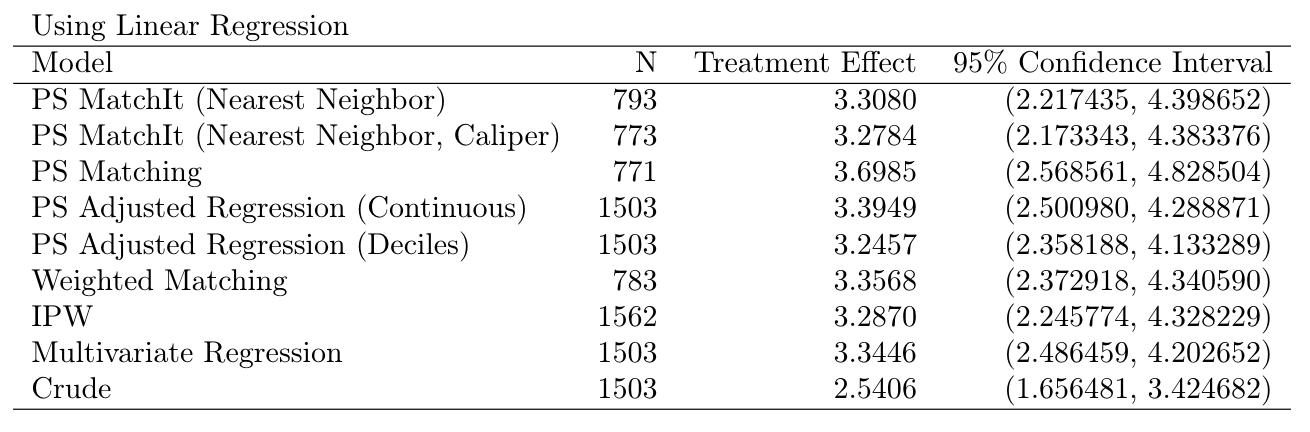

In [573]:
library("IRdisplay")
display_png(file="table.png")  

The next step would be to play with the functional form of the covariates a bit more, potentially add in a few more covariates (such as `tax71`), and possibly compare these models to the performance of a machine learning algorithm.  
  
I hope this was helpful in some way. If you see errors of any kind, give me a holler :)